In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [8]:
df = pd.read_csv('train.csv', sep = ',')
X = df.loc[:,'var_0':'var_199']
Y = df.loc[:,'target']
X.head()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,5.7470,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,8.0851,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,5.9525,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,8.2450,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,7.6784,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [9]:
fraud_index = np.where(Y==1)
honest_index = np.where(Y==0)
fraud = X.loc[fraud_index]
honest = X.loc[honest_index]

In [10]:
yh = Y.loc[honest_index]
yf = Y.loc[fraud_index]

In [11]:
h_train, h_test, hy_train, hy_test = train_test_split(honest, yh,test_size=0.3,
                                                      random_state=30)
h_test, h_val, hy_test, hy_val = train_test_split(h_test, hy_test,test_size=0.5,
                                                  random_state=30)


f_train, f_test, fy_train, fy_test = train_test_split(fraud, yf,test_size=0.3,
                                                      random_state=30)
f_test, f_val, fy_test, fy_val = train_test_split(f_test, fy_test,test_size=0.5,
                                                  random_state=30)


In [12]:
len(h_train)/len(f_train)

8.951592266135911

In [13]:
f_train = pd.concat([f_train, f_train, f_train], ignore_index=False)
fy_train = pd.concat([fy_train, fy_train, fy_train], ignore_index=False)

In [14]:
len(h_train)/len(f_train)

2.9838640887119703

In [15]:
x_train = pd.concat([h_train,f_train],ignore_index = True)
x_test = pd.concat([h_test,f_test],ignore_index = True)
x_val = pd.concat([h_val,f_val],ignore_index = True)

y_train = pd.concat([hy_train,fy_train],ignore_index = True)
y_test = pd.concat([hy_test,fy_test],ignore_index = True)
y_val = pd.concat([hy_val,fy_val],ignore_index = True)

In [16]:
meanx = x_train.mean(axis = 0)
stdx = x_train.std(axis = 0)
x_train_norm = (x_train - meanx)/stdx
x_val_norm = (x_val - meanx)/stdx
x_test_norm = (x_test - meanx)/stdx
x_train_norm=np.asarray(x_train_norm)
x_test_norm=np.asarray(x_test_norm)
x_val_norm=np.asarray(x_val_norm)

In [17]:
import keras
from keras import models
from keras import layers
import tensorflow as tf
from keras.backend import binary_crossentropy
from keras import backend as K
from keras.callbacks import Callback
from keras import optimizers
from keras.backend import mean
from keras import regularizers
from keras.layers import Dropout

Using TensorFlow backend.


In [18]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
K.clear_session()

In [19]:
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)
y_val = np.asarray(y_val)

In [20]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [21]:
from sklearn.utils.multiclass import unique_labels
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [22]:
class new_rna:
    def build_model(self,data_shape,units_list,activation_list,dropout_list):
        self.model = models.Sequential()
        if len(dropout_list)==0:
            my_init = keras.initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=1)
            for i in range(len(units_list)):
                if i == 0:
                    self.model.add(layers.Dense(units=units_list[i], activation=activation_list[i],
                                                kernel_initializer = my_init,
                                                input_shape=data_shape))
                else:
                    self.model.add(layers.Dense(units=units_list[i], activation=activation_list[i]))
        else:
            my_init = keras.initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=1)
            for i in range(len(units_list)):
                if i == 0:
                    self.model.add(layers.Dense(units=units_list[i], activation=activation_list[i], kernel_initializer = my_init,
                                                input_shape=data_shape,kernel_regularizer = regularizers.l2(0.01)))
                elif i < (len(units_list)-1):
                    self.model.add(layers.Dropout(dropout_list[i-1]))
                    self.model.add(layers.Dense(units=units_list[i], activation=activation_list[i],
                                               kernel_regularizer = regularizers.l2(0.01)))
                else:
                    self.model.add(layers.Dropout(dropout_list[i-1]))
                    self.model.add(layers.Dense(units=units_list[i], activation=activation_list[i]))
        self.model.summary()
           
    def train(self,x_train,y_train,x_val,y_val,batch_size,epochs,loss,metric):
        mom = optimizers.SGD(lr=0.01, decay=0, momentum=0.9, nesterov=True)
        self.model.compile(loss = [loss],metrics = [metric], optimizer = mom)
        history = self.model.fit(x_train,y_train,batch_size = batch_size,epochs = epochs,validation_data = (x_val,y_val))
        self.history_dict = history.history
        self.aux_train = 1
        
    def plot(self):
        if (self.aux_train == 1):
            self.aux_plt = 1
            cost = self.history_dict['loss']
            metric = self.history_dict['f1']
            val_cost = self.history_dict['val_loss']
            val_metric = self.history_dict['val_f1']
            aux_epocas = range(1,len(cost)+1)
            plt.plot(aux_epocas,cost,'b',label = 'Custo - treinamento', color = 'red')
            plt.plot(aux_epocas,val_cost,'b',label = 'Custo - validacao', color = 'blue')
            plt.title(' Valor da Funcao Custo = Treinamento e Validacao')
            plt.xlabel('Épocas')
            plt.ylabel('Custo')
            plt.legend()
            plt.show()
            plt.plot(aux_epocas, metric,'b',label = 'metrica - treinamento',color = 'red')
            plt.plot(aux_epocas, val_metric,'b',label = 'metrica - validacao', color = 'blue')
            plt.title('Valor da métrica – treinamento e validação')
            plt.xlabel('Épocas')
            plt.ylabel('Acertividade')
            plt.legend()
            plt.show()
        else:
            print('Train before plot')

    def predict(self,x_data,y_data):
        if (self.aux_plt == 1):
            class_names = np.array([['Honest'],['Fraud']])
            subtitle = ['Test', 'Val', 'Train']
            for i in range(len(x_data)):
                y_hat = self.model.predict(x_data[i])
                yy_hat = np.round(y_hat)
                yy_hat = yy_hat.astype(int)
                yy_hat = np.ravel(yy_hat)
                f1 = f1_score(y_data[i],yy_hat)
                plot_confusion_matrix(np.int_(y_data[i]), np.int_(yy_hat), classes=class_names,
                                      title='F1_Score = {0}: {1} Data'.format(f1, subtitle[i]))
                plt.show()
            K.clear_session()
        else:
            print('Train before predict')

In [23]:
data_shape = (200,)

loss = 'binary_crossentropy'
metric = f1
batch_size = 25
epochs = 1000

x_data = [x_test_norm,x_val_norm,x_train_norm]
y_data = [y_test,y_val,y_train]

In [24]:
n_list0 = [50,1]
activation_list0 = ['tanh','sigmoid']
dropout_list0 = [0.1]

In [25]:
rna0 = new_rna()
rna0.build_model(data_shape,n_list0,activation_list0,dropout_list0)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                10050     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 10,101
Trainable params: 10,101
Non-trainable params: 0
_________________________________________________________________


Instructions for updating:
Use tf.cast instead.
Train on 168135 samples, validate on 30001 samples
Epoch 1/1000
168135/168135 [==============================] - 7s 43us/step - loss: 0.4349 - f1: 0.5460 - val_loss: 0.3333 - val_f1: 0.0678
Epoch 2/1000
168135/168135 [==============================] - 7s 42us/step - loss: 0.4302 - f1: 0.5531 - val_loss: 0.3201 - val_f1: 0.0633
Epoch 3/1000
168135/168135 [==============================] - 7s 41us/step - loss: 0.4304 - f1: 0.5492 - val_loss: 0.3182 - val_f1: 0.0659
Epoch 4/1000
168135/168135 [==============================] - 7s 41us/step - loss: 0.4307 - f1: 0.5482 - val_loss: 0.3209 - val_f1: 0.0665
Epoch 5/1000
168135/168135 [==============================] - 7s 42us/step - loss: 0.4305 - f1: 0.5484 - val_loss: 0.3228 - val_f1: 0.0670
Epoch 6/1000
168135/168135 [==============================] - 7s 41us/step - loss: 0.4303 - f1: 0.5516 - val_loss: 0.3086 - val_f1: 0.0620
Epoch 7/1000
168135/168135 [==============================] - 7s 42

168135/168135 [==============================] - 7s 42us/step - loss: 0.4304 - f1: 0.5474 - val_loss: 0.3301 - val_f1: 0.0672
Epoch 58/1000
168135/168135 [==============================] - 7s 43us/step - loss: 0.4301 - f1: 0.5484 - val_loss: 0.3037 - val_f1: 0.0597
Epoch 59/1000
168135/168135 [==============================] - 7s 41us/step - loss: 0.4307 - f1: 0.5490 - val_loss: 0.3229 - val_f1: 0.0683
Epoch 60/1000
168135/168135 [==============================] - 7s 43us/step - loss: 0.4308 - f1: 0.5487 - val_loss: 0.3198 - val_f1: 0.0667
Epoch 61/1000
168135/168135 [==============================] - 7s 41us/step - loss: 0.4306 - f1: 0.5488 - val_loss: 0.3245 - val_f1: 0.0662
Epoch 62/1000
168135/168135 [==============================] - 7s 43us/step - loss: 0.4311 - f1: 0.5455 - val_loss: 0.3179 - val_f1: 0.0624
Epoch 63/1000
168135/168135 [==============================] - 7s 42us/step - loss: 0.4306 - f1: 0.5482 - val_loss: 0.3163 - val_f1: 0.0654
Epoch 64/1000
168135/168135 [=====

168135/168135 [==============================] - 7s 41us/step - loss: 0.4307 - f1: 0.5506 - val_loss: 0.3195 - val_f1: 0.0633
Epoch 116/1000
168135/168135 [==============================] - 7s 42us/step - loss: 0.4306 - f1: 0.5489 - val_loss: 0.3149 - val_f1: 0.0655
Epoch 117/1000
168135/168135 [==============================] - 7s 43us/step - loss: 0.4306 - f1: 0.5495 - val_loss: 0.3107 - val_f1: 0.0624
Epoch 118/1000
168135/168135 [==============================] - 7s 42us/step - loss: 0.4305 - f1: 0.5489 - val_loss: 0.3195 - val_f1: 0.0639
Epoch 119/1000
168135/168135 [==============================] - 7s 42us/step - loss: 0.4304 - f1: 0.5471 - val_loss: 0.3329 - val_f1: 0.0640
Epoch 120/1000
168135/168135 [==============================] - 7s 42us/step - loss: 0.4307 - f1: 0.5473 - val_loss: 0.3175 - val_f1: 0.0655
Epoch 121/1000
168135/168135 [==============================] - 7s 43us/step - loss: 0.4301 - f1: 0.5479 - val_loss: 0.3133 - val_f1: 0.0652
Epoch 122/1000
168135/168135

168135/168135 [==============================] - 7s 43us/step - loss: 0.4310 - f1: 0.5478 - val_loss: 0.3253 - val_f1: 0.0674
Epoch 174/1000
168135/168135 [==============================] - 7s 42us/step - loss: 0.4311 - f1: 0.5472 - val_loss: 0.3079 - val_f1: 0.0617
Epoch 175/1000
168135/168135 [==============================] - 7s 43us/step - loss: 0.4308 - f1: 0.5463 - val_loss: 0.3192 - val_f1: 0.0661
Epoch 176/1000
168135/168135 [==============================] - 7s 42us/step - loss: 0.4309 - f1: 0.5480 - val_loss: 0.3163 - val_f1: 0.0643
Epoch 177/1000
168135/168135 [==============================] - 7s 42us/step - loss: 0.4303 - f1: 0.5502 - val_loss: 0.3194 - val_f1: 0.0655
Epoch 178/1000
168135/168135 [==============================] - 7s 44us/step - loss: 0.4306 - f1: 0.5494 - val_loss: 0.3168 - val_f1: 0.0640
Epoch 179/1000
168135/168135 [==============================] - 7s 42us/step - loss: 0.4302 - f1: 0.5470 - val_loss: 0.3118 - val_f1: 0.0630
Epoch 180/1000
168135/168135

168135/168135 [==============================] - 7s 43us/step - loss: 0.4303 - f1: 0.5507 - val_loss: 0.3057 - val_f1: 0.0600
Epoch 232/1000
168135/168135 [==============================] - 7s 42us/step - loss: 0.4303 - f1: 0.5486 - val_loss: 0.3252 - val_f1: 0.0688
Epoch 233/1000
168135/168135 [==============================] - 7s 43us/step - loss: 0.4308 - f1: 0.5443 - val_loss: 0.3339 - val_f1: 0.0665
Epoch 234/1000
168135/168135 [==============================] - 7s 43us/step - loss: 0.4304 - f1: 0.5507 - val_loss: 0.3145 - val_f1: 0.0621
Epoch 235/1000
168135/168135 [==============================] - 7s 42us/step - loss: 0.4307 - f1: 0.5484 - val_loss: 0.3246 - val_f1: 0.0674
Epoch 236/1000
168135/168135 [==============================] - 7s 44us/step - loss: 0.4308 - f1: 0.5485 - val_loss: 0.3185 - val_f1: 0.0658
Epoch 237/1000
168135/168135 [==============================] - 7s 42us/step - loss: 0.4304 - f1: 0.5474 - val_loss: 0.3191 - val_f1: 0.0653
Epoch 238/1000
168135/168135

168135/168135 [==============================] - 7s 43us/step - loss: 0.4305 - f1: 0.5472 - val_loss: 0.3188 - val_f1: 0.0655
Epoch 290/1000
168135/168135 [==============================] - 7s 42us/step - loss: 0.4306 - f1: 0.5496 - val_loss: 0.3173 - val_f1: 0.0638
Epoch 291/1000
168135/168135 [==============================] - 7s 43us/step - loss: 0.4309 - f1: 0.5472 - val_loss: 0.3178 - val_f1: 0.0651
Epoch 292/1000
168135/168135 [==============================] - 7s 42us/step - loss: 0.4308 - f1: 0.5486 - val_loss: 0.3231 - val_f1: 0.0661
Epoch 293/1000
168135/168135 [==============================] - 7s 42us/step - loss: 0.4306 - f1: 0.5472 - val_loss: 0.3134 - val_f1: 0.0645
Epoch 294/1000
168135/168135 [==============================] - 7s 43us/step - loss: 0.4305 - f1: 0.5480 - val_loss: 0.3160 - val_f1: 0.0637
Epoch 295/1000
168135/168135 [==============================] - 7s 43us/step - loss: 0.4304 - f1: 0.5480 - val_loss: 0.3321 - val_f1: 0.0677
Epoch 296/1000
168135/168135

168135/168135 [==============================] - 7s 43us/step - loss: 0.4306 - f1: 0.5488 - val_loss: 0.3160 - val_f1: 0.0625
Epoch 348/1000
168135/168135 [==============================] - 7s 42us/step - loss: 0.4307 - f1: 0.5472 - val_loss: 0.3195 - val_f1: 0.0650
Epoch 349/1000
168135/168135 [==============================] - 7s 43us/step - loss: 0.4301 - f1: 0.5500 - val_loss: 0.3364 - val_f1: 0.0698
Epoch 350/1000
168135/168135 [==============================] - 7s 42us/step - loss: 0.4304 - f1: 0.5497 - val_loss: 0.3216 - val_f1: 0.0665
Epoch 351/1000
168135/168135 [==============================] - 7s 43us/step - loss: 0.4308 - f1: 0.5488 - val_loss: 0.3213 - val_f1: 0.0625
Epoch 352/1000
168135/168135 [==============================] - 7s 43us/step - loss: 0.4305 - f1: 0.5463 - val_loss: 0.3223 - val_f1: 0.0668
Epoch 353/1000
168135/168135 [==============================] - 7s 42us/step - loss: 0.4308 - f1: 0.5472 - val_loss: 0.3267 - val_f1: 0.0664
Epoch 354/1000
168135/168135

168135/168135 [==============================] - 7s 43us/step - loss: 0.4305 - f1: 0.5471 - val_loss: 0.3276 - val_f1: 0.0680
Epoch 406/1000
168135/168135 [==============================] - 7s 42us/step - loss: 0.4307 - f1: 0.5491 - val_loss: 0.3324 - val_f1: 0.0691
Epoch 407/1000
168135/168135 [==============================] - 7s 43us/step - loss: 0.4305 - f1: 0.5467 - val_loss: 0.3198 - val_f1: 0.0648
Epoch 408/1000
168135/168135 [==============================] - 7s 42us/step - loss: 0.4301 - f1: 0.5506 - val_loss: 0.3237 - val_f1: 0.0685
Epoch 409/1000
168135/168135 [==============================] - 7s 43us/step - loss: 0.4308 - f1: 0.5484 - val_loss: 0.3247 - val_f1: 0.0676
Epoch 410/1000
168135/168135 [==============================] - 7s 43us/step - loss: 0.4309 - f1: 0.5473 - val_loss: 0.3189 - val_f1: 0.0664
Epoch 411/1000
168135/168135 [==============================] - 7s 42us/step - loss: 0.4300 - f1: 0.5511 - val_loss: 0.3241 - val_f1: 0.0680
Epoch 412/1000
168135/168135

168135/168135 [==============================] - 7s 44us/step - loss: 0.4301 - f1: 0.5504 - val_loss: 0.3287 - val_f1: 0.0678
Epoch 464/1000
168135/168135 [==============================] - 7s 42us/step - loss: 0.4305 - f1: 0.5528 - val_loss: 0.3250 - val_f1: 0.0678
Epoch 465/1000
168135/168135 [==============================] - 7s 42us/step - loss: 0.4309 - f1: 0.5448 - val_loss: 0.3401 - val_f1: 0.0695
Epoch 466/1000
168135/168135 [==============================] - 7s 44us/step - loss: 0.4306 - f1: 0.5509 - val_loss: 0.3247 - val_f1: 0.0673
Epoch 467/1000
168135/168135 [==============================] - 7s 42us/step - loss: 0.4303 - f1: 0.5475 - val_loss: 0.3225 - val_f1: 0.0663
Epoch 468/1000
168135/168135 [==============================] - 7s 43us/step - loss: 0.4304 - f1: 0.5490 - val_loss: 0.3118 - val_f1: 0.0637
Epoch 469/1000
168135/168135 [==============================] - 7s 42us/step - loss: 0.4305 - f1: 0.5501 - val_loss: 0.3294 - val_f1: 0.0663
Epoch 470/1000
168135/168135

168135/168135 [==============================] - 7s 43us/step - loss: 0.4306 - f1: 0.5479 - val_loss: 0.3172 - val_f1: 0.0660
Epoch 522/1000
168135/168135 [==============================] - 7s 43us/step - loss: 0.4307 - f1: 0.5480 - val_loss: 0.3267 - val_f1: 0.0678
Epoch 523/1000
168135/168135 [==============================] - 7s 43us/step - loss: 0.4307 - f1: 0.5468 - val_loss: 0.3289 - val_f1: 0.0675
Epoch 524/1000
168135/168135 [==============================] - 7s 42us/step - loss: 0.4301 - f1: 0.5520 - val_loss: 0.3233 - val_f1: 0.0655
Epoch 525/1000
168135/168135 [==============================] - 7s 42us/step - loss: 0.4307 - f1: 0.5494 - val_loss: 0.3200 - val_f1: 0.0631
Epoch 526/1000
168135/168135 [==============================] - 7s 44us/step - loss: 0.4303 - f1: 0.5464 - val_loss: 0.3171 - val_f1: 0.0666
Epoch 527/1000
168135/168135 [==============================] - 7s 42us/step - loss: 0.4303 - f1: 0.5488 - val_loss: 0.3190 - val_f1: 0.0630
Epoch 528/1000
168135/168135

168135/168135 [==============================] - 7s 43us/step - loss: 0.4306 - f1: 0.5456 - val_loss: 0.3145 - val_f1: 0.0634
Epoch 580/1000
168135/168135 [==============================] - 7s 42us/step - loss: 0.4303 - f1: 0.5502 - val_loss: 0.3194 - val_f1: 0.0644
Epoch 581/1000
168135/168135 [==============================] - 7s 43us/step - loss: 0.4303 - f1: 0.5517 - val_loss: 0.3362 - val_f1: 0.0659
Epoch 582/1000
168135/168135 [==============================] - 7s 42us/step - loss: 0.4305 - f1: 0.5486 - val_loss: 0.3100 - val_f1: 0.0617
Epoch 583/1000
168135/168135 [==============================] - 7s 43us/step - loss: 0.4304 - f1: 0.5491 - val_loss: 0.3202 - val_f1: 0.0657
Epoch 584/1000
168135/168135 [==============================] - 7s 43us/step - loss: 0.4307 - f1: 0.5496 - val_loss: 0.3086 - val_f1: 0.0618
Epoch 585/1000
168135/168135 [==============================] - 7s 42us/step - loss: 0.4303 - f1: 0.5499 - val_loss: 0.3272 - val_f1: 0.0674
Epoch 586/1000
168135/168135

168135/168135 [==============================] - 7s 43us/step - loss: 0.4308 - f1: 0.5480 - val_loss: 0.3201 - val_f1: 0.0638
Epoch 638/1000
168135/168135 [==============================] - 7s 42us/step - loss: 0.4303 - f1: 0.5450 - val_loss: 0.3170 - val_f1: 0.0648
Epoch 639/1000
168135/168135 [==============================] - 7s 44us/step - loss: 0.4303 - f1: 0.5478 - val_loss: 0.3295 - val_f1: 0.0667
Epoch 640/1000
168135/168135 [==============================] - 7s 42us/step - loss: 0.4306 - f1: 0.5479 - val_loss: 0.3128 - val_f1: 0.0627
Epoch 641/1000
168135/168135 [==============================] - 7s 43us/step - loss: 0.4305 - f1: 0.5478 - val_loss: 0.3188 - val_f1: 0.0642
Epoch 642/1000
168135/168135 [==============================] - 7s 42us/step - loss: 0.4304 - f1: 0.5476 - val_loss: 0.3141 - val_f1: 0.0654
Epoch 643/1000
168135/168135 [==============================] - 7s 44us/step - loss: 0.4302 - f1: 0.5489 - val_loss: 0.3203 - val_f1: 0.0670
Epoch 644/1000
168135/168135

168135/168135 [==============================] - 7s 45us/step - loss: 0.4306 - f1: 0.5460 - val_loss: 0.3334 - val_f1: 0.0665
Epoch 696/1000
168135/168135 [==============================] - 7s 42us/step - loss: 0.4303 - f1: 0.5481 - val_loss: 0.3191 - val_f1: 0.0622
Epoch 697/1000
168135/168135 [==============================] - 7s 43us/step - loss: 0.4304 - f1: 0.5472 - val_loss: 0.3257 - val_f1: 0.0664
Epoch 698/1000
168135/168135 [==============================] - 7s 43us/step - loss: 0.4308 - f1: 0.5475 - val_loss: 0.3315 - val_f1: 0.0679
Epoch 699/1000
168135/168135 [==============================] - 7s 43us/step - loss: 0.4303 - f1: 0.5486 - val_loss: 0.3164 - val_f1: 0.0613
Epoch 700/1000
168135/168135 [==============================] - 7s 42us/step - loss: 0.4301 - f1: 0.5480 - val_loss: 0.3255 - val_f1: 0.0665
Epoch 701/1000
168135/168135 [==============================] - 7s 44us/step - loss: 0.4307 - f1: 0.5473 - val_loss: 0.3153 - val_f1: 0.0637
Epoch 702/1000
168135/168135

168135/168135 [==============================] - 7s 42us/step - loss: 0.4303 - f1: 0.5495 - val_loss: 0.3152 - val_f1: 0.0655
Epoch 754/1000
168135/168135 [==============================] - 7s 43us/step - loss: 0.4304 - f1: 0.5479 - val_loss: 0.3202 - val_f1: 0.0663
Epoch 755/1000
168135/168135 [==============================] - 7s 44us/step - loss: 0.4308 - f1: 0.5488 - val_loss: 0.3409 - val_f1: 0.0690
Epoch 756/1000
168135/168135 [==============================] - 7s 43us/step - loss: 0.4303 - f1: 0.5489 - val_loss: 0.3171 - val_f1: 0.0649
Epoch 757/1000
168135/168135 [==============================] - 7s 43us/step - loss: 0.4306 - f1: 0.5451 - val_loss: 0.3160 - val_f1: 0.0639
Epoch 758/1000
168135/168135 [==============================] - 7s 43us/step - loss: 0.4305 - f1: 0.5491 - val_loss: 0.3247 - val_f1: 0.0668
Epoch 759/1000
168135/168135 [==============================] - 7s 43us/step - loss: 0.4302 - f1: 0.5505 - val_loss: 0.3128 - val_f1: 0.0632
Epoch 760/1000
168135/168135

168135/168135 [==============================] - 7s 42us/step - loss: 0.4303 - f1: 0.5486 - val_loss: 0.3288 - val_f1: 0.0688
Epoch 812/1000
168135/168135 [==============================] - 7s 43us/step - loss: 0.4306 - f1: 0.5485 - val_loss: 0.3318 - val_f1: 0.0667
Epoch 813/1000
168135/168135 [==============================] - 7s 42us/step - loss: 0.4306 - f1: 0.5475 - val_loss: 0.3258 - val_f1: 0.0693
Epoch 814/1000
168135/168135 [==============================] - 7s 43us/step - loss: 0.4303 - f1: 0.5484 - val_loss: 0.3367 - val_f1: 0.0695
Epoch 815/1000
168135/168135 [==============================] - 7s 43us/step - loss: 0.4307 - f1: 0.5493 - val_loss: 0.3182 - val_f1: 0.0659
Epoch 816/1000
168135/168135 [==============================] - 7s 42us/step - loss: 0.4306 - f1: 0.5472 - val_loss: 0.3150 - val_f1: 0.0633
Epoch 817/1000
168135/168135 [==============================] - 7s 43us/step - loss: 0.4307 - f1: 0.5460 - val_loss: 0.3196 - val_f1: 0.0663
Epoch 818/1000
168135/168135

168135/168135 [==============================] - 7s 42us/step - loss: 0.4309 - f1: 0.5489 - val_loss: 0.3164 - val_f1: 0.0663
Epoch 870/1000
168135/168135 [==============================] - 7s 43us/step - loss: 0.4309 - f1: 0.5485 - val_loss: 0.3249 - val_f1: 0.0671
Epoch 871/1000
168135/168135 [==============================] - 7s 42us/step - loss: 0.4301 - f1: 0.5502 - val_loss: 0.3285 - val_f1: 0.0672
Epoch 872/1000
168135/168135 [==============================] - 7s 43us/step - loss: 0.4306 - f1: 0.5487 - val_loss: 0.3379 - val_f1: 0.0664
Epoch 873/1000
168135/168135 [==============================] - 7s 42us/step - loss: 0.4303 - f1: 0.5510 - val_loss: 0.3284 - val_f1: 0.0673
Epoch 874/1000
168135/168135 [==============================] - 7s 43us/step - loss: 0.4308 - f1: 0.5477 - val_loss: 0.3214 - val_f1: 0.0678
Epoch 875/1000
168135/168135 [==============================] - 7s 43us/step - loss: 0.4305 - f1: 0.5492 - val_loss: 0.3020 - val_f1: 0.0579
Epoch 876/1000
168135/168135

168135/168135 [==============================] - 7s 42us/step - loss: 0.4303 - f1: 0.5492 - val_loss: 0.3065 - val_f1: 0.0622
Epoch 928/1000
168135/168135 [==============================] - 7s 44us/step - loss: 0.4308 - f1: 0.5501 - val_loss: 0.3246 - val_f1: 0.0642
Epoch 929/1000
168135/168135 [==============================] - 7s 42us/step - loss: 0.4306 - f1: 0.5483 - val_loss: 0.3185 - val_f1: 0.0650
Epoch 930/1000
168135/168135 [==============================] - 7s 43us/step - loss: 0.4305 - f1: 0.5491 - val_loss: 0.3319 - val_f1: 0.0659
Epoch 931/1000
168135/168135 [==============================] - 7s 42us/step - loss: 0.4304 - f1: 0.5472 - val_loss: 0.3015 - val_f1: 0.0601
Epoch 932/1000
168135/168135 [==============================] - 7s 43us/step - loss: 0.4308 - f1: 0.5479 - val_loss: 0.3089 - val_f1: 0.0646
Epoch 933/1000
168135/168135 [==============================] - 7s 43us/step - loss: 0.4309 - f1: 0.5483 - val_loss: 0.3112 - val_f1: 0.0650
Epoch 934/1000
168135/168135

168135/168135 [==============================] - 7s 43us/step - loss: 0.4304 - f1: 0.5491 - val_loss: 0.3205 - val_f1: 0.0649
Epoch 986/1000
168135/168135 [==============================] - 7s 44us/step - loss: 0.4305 - f1: 0.5478 - val_loss: 0.3424 - val_f1: 0.0714
Epoch 987/1000
168135/168135 [==============================] - 7s 42us/step - loss: 0.4308 - f1: 0.5468 - val_loss: 0.3222 - val_f1: 0.0643
Epoch 988/1000
168135/168135 [==============================] - 7s 43us/step - loss: 0.4302 - f1: 0.5486 - val_loss: 0.3127 - val_f1: 0.0634
Epoch 989/1000
168135/168135 [==============================] - 7s 42us/step - loss: 0.4301 - f1: 0.5484 - val_loss: 0.3264 - val_f1: 0.0645
Epoch 990/1000
168135/168135 [==============================] - 7s 43us/step - loss: 0.4305 - f1: 0.5481 - val_loss: 0.3191 - val_f1: 0.0648
Epoch 991/1000
168135/168135 [==============================] - 7s 43us/step - loss: 0.4307 - f1: 0.5515 - val_loss: 0.3251 - val_f1: 0.0655
Epoch 992/1000
168135/168135

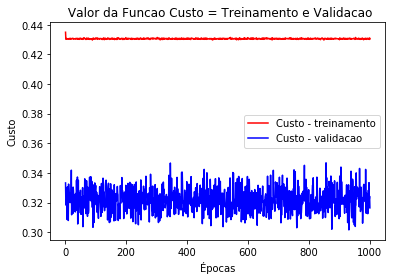

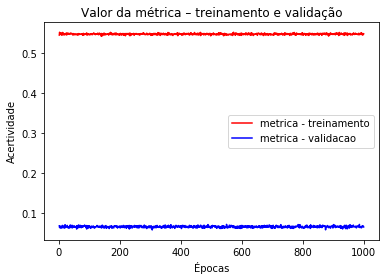

In [26]:
rna0.train(x_train_norm,y_train,x_val_norm,y_val,batch_size,epochs,loss,metric)
rna0.plot()

Confusion matrix, without normalization
[[25245  1740]
 [ 1600  1415]]


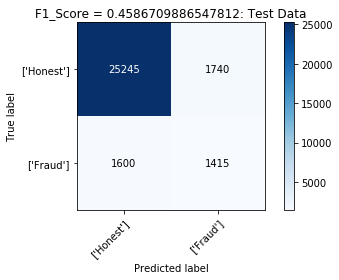

Confusion matrix, without normalization
[[25285  1701]
 [ 1560  1455]]


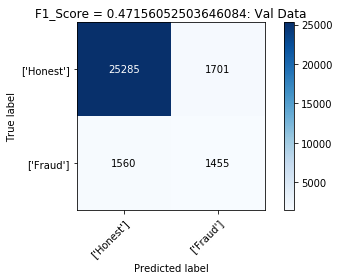

Confusion matrix, without normalization
[[118010   7921]
 [ 22257  19947]]


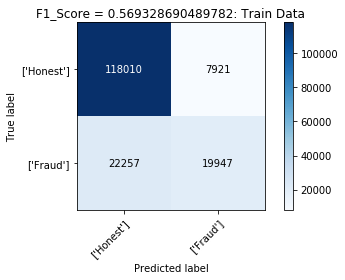

In [27]:
rna0.predict(x_data,y_data)

In [28]:
n_list1 = [100,1]
activation_list1 = ['tanh','sigmoid']
dropout_list1 = [0.1]

In [29]:
rna1 = new_rna()
rna1.build_model(data_shape,n_list1,activation_list1,dropout_list1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 20,201
Trainable params: 20,201
Non-trainable params: 0
_________________________________________________________________


Train on 168135 samples, validate on 30001 samples
Epoch 1/1000
168135/168135 [==============================] - 8s 49us/step - loss: 0.4380 - f1: 0.5458 - val_loss: 0.3260 - val_f1: 0.0669
Epoch 2/1000
168135/168135 [==============================] - 7s 44us/step - loss: 0.4301 - f1: 0.5486 - val_loss: 0.3269 - val_f1: 0.0646
Epoch 3/1000
168135/168135 [==============================] - 8s 46us/step - loss: 0.4302 - f1: 0.5494 - val_loss: 0.3257 - val_f1: 0.0680
Epoch 4/1000
168135/168135 [==============================] - 7s 45us/step - loss: 0.4299 - f1: 0.5470 - val_loss: 0.3259 - val_f1: 0.0666
Epoch 5/1000
168135/168135 [==============================] - 8s 45us/step - loss: 0.4303 - f1: 0.5489 - val_loss: 0.3142 - val_f1: 0.0590
Epoch 6/1000
168135/168135 [==============================] - 7s 44us/step - loss: 0.4302 - f1: 0.5460 - val_loss: 0.3351 - val_f1: 0.0670
Epoch 7/1000
168135/168135 [==============================] - 8s 46us/step - loss: 0.4306 - f1: 0.5470 - val_loss: 

168135/168135 [==============================] - 8s 47us/step - loss: 0.4305 - f1: 0.5489 - val_loss: 0.3205 - val_f1: 0.0669
Epoch 60/1000
168135/168135 [==============================] - 8s 46us/step - loss: 0.4304 - f1: 0.5501 - val_loss: 0.3305 - val_f1: 0.0674
Epoch 61/1000
168135/168135 [==============================] - 8s 47us/step - loss: 0.4303 - f1: 0.5471 - val_loss: 0.3215 - val_f1: 0.0661
Epoch 62/1000
168135/168135 [==============================] - 8s 46us/step - loss: 0.4306 - f1: 0.5458 - val_loss: 0.3221 - val_f1: 0.0650
Epoch 63/1000
168135/168135 [==============================] - 8s 47us/step - loss: 0.4306 - f1: 0.5481 - val_loss: 0.3250 - val_f1: 0.0654
Epoch 64/1000
168135/168135 [==============================] - 8s 46us/step - loss: 0.4303 - f1: 0.5514 - val_loss: 0.3217 - val_f1: 0.0638
Epoch 65/1000
168135/168135 [==============================] - 8s 47us/step - loss: 0.4305 - f1: 0.5475 - val_loss: 0.3272 - val_f1: 0.0658
Epoch 66/1000
168135/168135 [=====

168135/168135 [==============================] - 8s 48us/step - loss: 0.4305 - f1: 0.5488 - val_loss: 0.3186 - val_f1: 0.0665
Epoch 118/1000
168135/168135 [==============================] - 8s 46us/step - loss: 0.4303 - f1: 0.5485 - val_loss: 0.3325 - val_f1: 0.0647
Epoch 119/1000
168135/168135 [==============================] - 8s 47us/step - loss: 0.4305 - f1: 0.5490 - val_loss: 0.3183 - val_f1: 0.0647
Epoch 120/1000
168135/168135 [==============================] - 8s 47us/step - loss: 0.4305 - f1: 0.5449 - val_loss: 0.3211 - val_f1: 0.0679
Epoch 121/1000
168135/168135 [==============================] - 8s 47us/step - loss: 0.4304 - f1: 0.5449 - val_loss: 0.3260 - val_f1: 0.0667
Epoch 122/1000
168135/168135 [==============================] - 8s 47us/step - loss: 0.4306 - f1: 0.5474 - val_loss: 0.3303 - val_f1: 0.0671
Epoch 123/1000
168135/168135 [==============================] - 8s 48us/step - loss: 0.4300 - f1: 0.5464 - val_loss: 0.3139 - val_f1: 0.0638
Epoch 124/1000
168135/168135

168135/168135 [==============================] - 8s 46us/step - loss: 0.4303 - f1: 0.5491 - val_loss: 0.3271 - val_f1: 0.0670
Epoch 176/1000
168135/168135 [==============================] - 8s 48us/step - loss: 0.4308 - f1: 0.5487 - val_loss: 0.3297 - val_f1: 0.0660
Epoch 177/1000
168135/168135 [==============================] - 8s 46us/step - loss: 0.4306 - f1: 0.5461 - val_loss: 0.3183 - val_f1: 0.0631
Epoch 178/1000
168135/168135 [==============================] - 8s 48us/step - loss: 0.4307 - f1: 0.5474 - val_loss: 0.3335 - val_f1: 0.0682
Epoch 179/1000
168135/168135 [==============================] - 8s 46us/step - loss: 0.4306 - f1: 0.5504 - val_loss: 0.3134 - val_f1: 0.0619
Epoch 180/1000
168135/168135 [==============================] - 8s 48us/step - loss: 0.4304 - f1: 0.5471 - val_loss: 0.3130 - val_f1: 0.0658
Epoch 181/1000
168135/168135 [==============================] - 8s 47us/step - loss: 0.4303 - f1: 0.5459 - val_loss: 0.3292 - val_f1: 0.0682
Epoch 182/1000
168135/168135

168135/168135 [==============================] - 8s 47us/step - loss: 0.4307 - f1: 0.5490 - val_loss: 0.3205 - val_f1: 0.0638
Epoch 234/1000
168135/168135 [==============================] - 8s 46us/step - loss: 0.4308 - f1: 0.5484 - val_loss: 0.3269 - val_f1: 0.0670
Epoch 235/1000
168135/168135 [==============================] - 8s 47us/step - loss: 0.4305 - f1: 0.5470 - val_loss: 0.3186 - val_f1: 0.0660
Epoch 236/1000
168135/168135 [==============================] - 8s 47us/step - loss: 0.4303 - f1: 0.5471 - val_loss: 0.3155 - val_f1: 0.0626
Epoch 237/1000
168135/168135 [==============================] - 8s 46us/step - loss: 0.4302 - f1: 0.5488 - val_loss: 0.3229 - val_f1: 0.0633
Epoch 238/1000
168135/168135 [==============================] - 8s 47us/step - loss: 0.4307 - f1: 0.5471 - val_loss: 0.3290 - val_f1: 0.0636
Epoch 239/1000
168135/168135 [==============================] - 8s 47us/step - loss: 0.4301 - f1: 0.5507 - val_loss: 0.3211 - val_f1: 0.0655
Epoch 240/1000
168135/168135

168135/168135 [==============================] - 8s 48us/step - loss: 0.4303 - f1: 0.5457 - val_loss: 0.3242 - val_f1: 0.0662
Epoch 292/1000
168135/168135 [==============================] - 8s 47us/step - loss: 0.4304 - f1: 0.5498 - val_loss: 0.3090 - val_f1: 0.0634
Epoch 293/1000
168135/168135 [==============================] - 8s 47us/step - loss: 0.4300 - f1: 0.5477 - val_loss: 0.3290 - val_f1: 0.0681
Epoch 294/1000
168135/168135 [==============================] - 8s 47us/step - loss: 0.4294 - f1: 0.5491 - val_loss: 0.3279 - val_f1: 0.0664
Epoch 295/1000
168135/168135 [==============================] - 8s 47us/step - loss: 0.4305 - f1: 0.5497 - val_loss: 0.3226 - val_f1: 0.0647
Epoch 296/1000
168135/168135 [==============================] - 8s 47us/step - loss: 0.4302 - f1: 0.5491 - val_loss: 0.3095 - val_f1: 0.0595
Epoch 297/1000
168135/168135 [==============================] - 8s 47us/step - loss: 0.4298 - f1: 0.5489 - val_loss: 0.3291 - val_f1: 0.0689
Epoch 298/1000
168135/168135

168135/168135 [==============================] - 8s 47us/step - loss: 0.4310 - f1: 0.5463 - val_loss: 0.3187 - val_f1: 0.0645
Epoch 350/1000
168135/168135 [==============================] - 8s 47us/step - loss: 0.4302 - f1: 0.5450 - val_loss: 0.3117 - val_f1: 0.0617
Epoch 351/1000
168135/168135 [==============================] - 8s 47us/step - loss: 0.4305 - f1: 0.5483 - val_loss: 0.3262 - val_f1: 0.0654
Epoch 352/1000
168135/168135 [==============================] - 8s 47us/step - loss: 0.4304 - f1: 0.5485 - val_loss: 0.3072 - val_f1: 0.0623
Epoch 353/1000
168135/168135 [==============================] - 8s 47us/step - loss: 0.4306 - f1: 0.5467 - val_loss: 0.3148 - val_f1: 0.0645
Epoch 354/1000
168135/168135 [==============================] - 8s 47us/step - loss: 0.4308 - f1: 0.5478 - val_loss: 0.3190 - val_f1: 0.0653
Epoch 355/1000
168135/168135 [==============================] - 8s 47us/step - loss: 0.4306 - f1: 0.5476 - val_loss: 0.3180 - val_f1: 0.0650
Epoch 356/1000
168135/168135

168135/168135 [==============================] - 8s 47us/step - loss: 0.4307 - f1: 0.5468 - val_loss: 0.3196 - val_f1: 0.0662
Epoch 408/1000
168135/168135 [==============================] - 8s 48us/step - loss: 0.4304 - f1: 0.5475 - val_loss: 0.3149 - val_f1: 0.0642
Epoch 409/1000
168135/168135 [==============================] - 8s 47us/step - loss: 0.4305 - f1: 0.5447 - val_loss: 0.3240 - val_f1: 0.0639
Epoch 410/1000
168135/168135 [==============================] - 8s 47us/step - loss: 0.4304 - f1: 0.5497 - val_loss: 0.3371 - val_f1: 0.0678
Epoch 411/1000
168135/168135 [==============================] - 8s 47us/step - loss: 0.4304 - f1: 0.5495 - val_loss: 0.3385 - val_f1: 0.0674
Epoch 412/1000
168135/168135 [==============================] - 8s 46us/step - loss: 0.4308 - f1: 0.5470 - val_loss: 0.3174 - val_f1: 0.0643
Epoch 413/1000
168135/168135 [==============================] - 8s 47us/step - loss: 0.4307 - f1: 0.5452 - val_loss: 0.3097 - val_f1: 0.0618
Epoch 414/1000
168135/168135

168135/168135 [==============================] - 8s 48us/step - loss: 0.4303 - f1: 0.5481 - val_loss: 0.3410 - val_f1: 0.0683
Epoch 466/1000
168135/168135 [==============================] - 8s 47us/step - loss: 0.4308 - f1: 0.5464 - val_loss: 0.3251 - val_f1: 0.0662
Epoch 467/1000
168135/168135 [==============================] - 8s 48us/step - loss: 0.4302 - f1: 0.5473 - val_loss: 0.3214 - val_f1: 0.0666
Epoch 468/1000
168135/168135 [==============================] - 8s 47us/step - loss: 0.4303 - f1: 0.5488 - val_loss: 0.3200 - val_f1: 0.0646
Epoch 469/1000
168135/168135 [==============================] - 8s 48us/step - loss: 0.4301 - f1: 0.5487 - val_loss: 0.3213 - val_f1: 0.0644
Epoch 470/1000
168135/168135 [==============================] - 8s 47us/step - loss: 0.4305 - f1: 0.5476 - val_loss: 0.3128 - val_f1: 0.0622
Epoch 471/1000
168135/168135 [==============================] - 8s 49us/step - loss: 0.4301 - f1: 0.5481 - val_loss: 0.3151 - val_f1: 0.0648
Epoch 472/1000
168135/168135

168135/168135 [==============================] - 8s 48us/step - loss: 0.4303 - f1: 0.5447 - val_loss: 0.3331 - val_f1: 0.0694
Epoch 524/1000
168135/168135 [==============================] - 8s 47us/step - loss: 0.4305 - f1: 0.5500 - val_loss: 0.3181 - val_f1: 0.0659
Epoch 525/1000
168135/168135 [==============================] - 8s 48us/step - loss: 0.4300 - f1: 0.5468 - val_loss: 0.3229 - val_f1: 0.0683
Epoch 526/1000
168135/168135 [==============================] - 8s 47us/step - loss: 0.4302 - f1: 0.5475 - val_loss: 0.3236 - val_f1: 0.0665
Epoch 527/1000
168135/168135 [==============================] - 8s 48us/step - loss: 0.4300 - f1: 0.5509 - val_loss: 0.3226 - val_f1: 0.0677
Epoch 528/1000
168135/168135 [==============================] - 8s 47us/step - loss: 0.4308 - f1: 0.5489 - val_loss: 0.3248 - val_f1: 0.0656
Epoch 529/1000
168135/168135 [==============================] - 8s 48us/step - loss: 0.4305 - f1: 0.5474 - val_loss: 0.3179 - val_f1: 0.0621
Epoch 530/1000
168135/168135

168135/168135 [==============================] - 8s 48us/step - loss: 0.4300 - f1: 0.5518 - val_loss: 0.3245 - val_f1: 0.0669
Epoch 582/1000
168135/168135 [==============================] - 8s 47us/step - loss: 0.4304 - f1: 0.5502 - val_loss: 0.3139 - val_f1: 0.0642
Epoch 583/1000
168135/168135 [==============================] - 8s 48us/step - loss: 0.4305 - f1: 0.5483 - val_loss: 0.3295 - val_f1: 0.0678
Epoch 584/1000
168135/168135 [==============================] - 8s 47us/step - loss: 0.4306 - f1: 0.5496 - val_loss: 0.3148 - val_f1: 0.0615
Epoch 585/1000
168135/168135 [==============================] - 8s 48us/step - loss: 0.4304 - f1: 0.5465 - val_loss: 0.3260 - val_f1: 0.0697
Epoch 586/1000
168135/168135 [==============================] - 8s 47us/step - loss: 0.4303 - f1: 0.5476 - val_loss: 0.3383 - val_f1: 0.0685
Epoch 587/1000
168135/168135 [==============================] - 8s 48us/step - loss: 0.4304 - f1: 0.5481 - val_loss: 0.3207 - val_f1: 0.0640
Epoch 588/1000
168135/168135

168135/168135 [==============================] - 8s 48us/step - loss: 0.4306 - f1: 0.5476 - val_loss: 0.3337 - val_f1: 0.0687
Epoch 640/1000
168135/168135 [==============================] - 8s 47us/step - loss: 0.4300 - f1: 0.5501 - val_loss: 0.3194 - val_f1: 0.0653
Epoch 641/1000
168135/168135 [==============================] - 8s 49us/step - loss: 0.4302 - f1: 0.5483 - val_loss: 0.3273 - val_f1: 0.0672
Epoch 642/1000
168135/168135 [==============================] - 8s 47us/step - loss: 0.4305 - f1: 0.5500 - val_loss: 0.3260 - val_f1: 0.0669
Epoch 643/1000
168135/168135 [==============================] - 8s 48us/step - loss: 0.4302 - f1: 0.5503 - val_loss: 0.3189 - val_f1: 0.0651
Epoch 644/1000
168135/168135 [==============================] - 8s 47us/step - loss: 0.4304 - f1: 0.5513 - val_loss: 0.3244 - val_f1: 0.0636
Epoch 645/1000
168135/168135 [==============================] - 8s 48us/step - loss: 0.4303 - f1: 0.5472 - val_loss: 0.3262 - val_f1: 0.0665
Epoch 646/1000
168135/168135

168135/168135 [==============================] - 8s 48us/step - loss: 0.4307 - f1: 0.5462 - val_loss: 0.3178 - val_f1: 0.0648
Epoch 698/1000
168135/168135 [==============================] - 8s 47us/step - loss: 0.4303 - f1: 0.5473 - val_loss: 0.3177 - val_f1: 0.0640
Epoch 699/1000
168135/168135 [==============================] - 8s 48us/step - loss: 0.4306 - f1: 0.5483 - val_loss: 0.3305 - val_f1: 0.0673
Epoch 700/1000
168135/168135 [==============================] - 8s 47us/step - loss: 0.4301 - f1: 0.5463 - val_loss: 0.3320 - val_f1: 0.0674
Epoch 701/1000
168135/168135 [==============================] - 8s 48us/step - loss: 0.4303 - f1: 0.5464 - val_loss: 0.3090 - val_f1: 0.0606
Epoch 702/1000
168135/168135 [==============================] - 8s 47us/step - loss: 0.4304 - f1: 0.5468 - val_loss: 0.3213 - val_f1: 0.0674
Epoch 703/1000
168135/168135 [==============================] - 8s 48us/step - loss: 0.4304 - f1: 0.5485 - val_loss: 0.3291 - val_f1: 0.0665
Epoch 704/1000
168135/168135

168135/168135 [==============================] - 8s 47us/step - loss: 0.4304 - f1: 0.5480 - val_loss: 0.3162 - val_f1: 0.0641
Epoch 756/1000
168135/168135 [==============================] - 8s 47us/step - loss: 0.4300 - f1: 0.5496 - val_loss: 0.3277 - val_f1: 0.0657
Epoch 757/1000
168135/168135 [==============================] - 8s 47us/step - loss: 0.4302 - f1: 0.5466 - val_loss: 0.3302 - val_f1: 0.0689
Epoch 758/1000
168135/168135 [==============================] - 8s 47us/step - loss: 0.4300 - f1: 0.5479 - val_loss: 0.3357 - val_f1: 0.0667
Epoch 759/1000
168135/168135 [==============================] - 8s 48us/step - loss: 0.4304 - f1: 0.5487 - val_loss: 0.3265 - val_f1: 0.0685
Epoch 760/1000
168135/168135 [==============================] - 8s 48us/step - loss: 0.4297 - f1: 0.5526 - val_loss: 0.3366 - val_f1: 0.0702
Epoch 761/1000
168135/168135 [==============================] - 8s 47us/step - loss: 0.4301 - f1: 0.5485 - val_loss: 0.3205 - val_f1: 0.0647
Epoch 762/1000
168135/168135

168135/168135 [==============================] - 8s 47us/step - loss: 0.4308 - f1: 0.5456 - val_loss: 0.3247 - val_f1: 0.0639
Epoch 814/1000
168135/168135 [==============================] - 8s 48us/step - loss: 0.4304 - f1: 0.5465 - val_loss: 0.3136 - val_f1: 0.0638
Epoch 815/1000
168135/168135 [==============================] - 8s 47us/step - loss: 0.4302 - f1: 0.5495 - val_loss: 0.3210 - val_f1: 0.0646
Epoch 816/1000
168135/168135 [==============================] - 8s 48us/step - loss: 0.4299 - f1: 0.5476 - val_loss: 0.3287 - val_f1: 0.0663
Epoch 817/1000
168135/168135 [==============================] - 8s 47us/step - loss: 0.4302 - f1: 0.5490 - val_loss: 0.3241 - val_f1: 0.0667
Epoch 818/1000
168135/168135 [==============================] - 8s 48us/step - loss: 0.4302 - f1: 0.5486 - val_loss: 0.3344 - val_f1: 0.0684
Epoch 819/1000
168135/168135 [==============================] - 8s 47us/step - loss: 0.4303 - f1: 0.5484 - val_loss: 0.3259 - val_f1: 0.0676
Epoch 820/1000
168135/168135

168135/168135 [==============================] - 8s 47us/step - loss: 0.4305 - f1: 0.5463 - val_loss: 0.3263 - val_f1: 0.0676
Epoch 872/1000
168135/168135 [==============================] - 8s 48us/step - loss: 0.4309 - f1: 0.5457 - val_loss: 0.3256 - val_f1: 0.0645
Epoch 873/1000
168135/168135 [==============================] - 8s 47us/step - loss: 0.4303 - f1: 0.5481 - val_loss: 0.3186 - val_f1: 0.0630
Epoch 874/1000
168135/168135 [==============================] - 8s 48us/step - loss: 0.4307 - f1: 0.5462 - val_loss: 0.3292 - val_f1: 0.0659
Epoch 875/1000
168135/168135 [==============================] - 8s 47us/step - loss: 0.4305 - f1: 0.5476 - val_loss: 0.3324 - val_f1: 0.0695
Epoch 876/1000
168135/168135 [==============================] - 8s 48us/step - loss: 0.4303 - f1: 0.5488 - val_loss: 0.3196 - val_f1: 0.0664
Epoch 877/1000
168135/168135 [==============================] - 8s 47us/step - loss: 0.4307 - f1: 0.5450 - val_loss: 0.3216 - val_f1: 0.0671
Epoch 878/1000
168135/168135

168135/168135 [==============================] - 8s 47us/step - loss: 0.4302 - f1: 0.5497 - val_loss: 0.3265 - val_f1: 0.0645
Epoch 930/1000
168135/168135 [==============================] - 8s 47us/step - loss: 0.4306 - f1: 0.5465 - val_loss: 0.3221 - val_f1: 0.0676
Epoch 931/1000
168135/168135 [==============================] - 8s 47us/step - loss: 0.4303 - f1: 0.5466 - val_loss: 0.3315 - val_f1: 0.0670
Epoch 932/1000
168135/168135 [==============================] - 8s 47us/step - loss: 0.4304 - f1: 0.5501 - val_loss: 0.3211 - val_f1: 0.0634
Epoch 933/1000
168135/168135 [==============================] - 8s 48us/step - loss: 0.4300 - f1: 0.5493 - val_loss: 0.3113 - val_f1: 0.0616
Epoch 934/1000
168135/168135 [==============================] - 8s 47us/step - loss: 0.4304 - f1: 0.5471 - val_loss: 0.3220 - val_f1: 0.0653
Epoch 935/1000
168135/168135 [==============================] - 8s 48us/step - loss: 0.4301 - f1: 0.5481 - val_loss: 0.3183 - val_f1: 0.0649
Epoch 936/1000
168135/168135

168135/168135 [==============================] - 8s 48us/step - loss: 0.4303 - f1: 0.5510 - val_loss: 0.3145 - val_f1: 0.0638
Epoch 988/1000
168135/168135 [==============================] - 8s 47us/step - loss: 0.4305 - f1: 0.5487 - val_loss: 0.3340 - val_f1: 0.0683
Epoch 989/1000
168135/168135 [==============================] - 8s 49us/step - loss: 0.4305 - f1: 0.5448 - val_loss: 0.3141 - val_f1: 0.0639
Epoch 990/1000
168135/168135 [==============================] - 8s 47us/step - loss: 0.4303 - f1: 0.5461 - val_loss: 0.3273 - val_f1: 0.0678
Epoch 991/1000
168135/168135 [==============================] - 8s 48us/step - loss: 0.4304 - f1: 0.5495 - val_loss: 0.3309 - val_f1: 0.0675
Epoch 992/1000
168135/168135 [==============================] - 8s 47us/step - loss: 0.4305 - f1: 0.5486 - val_loss: 0.3339 - val_f1: 0.0688
Epoch 993/1000
168135/168135 [==============================] - 8s 48us/step - loss: 0.4305 - f1: 0.5475 - val_loss: 0.3240 - val_f1: 0.0649
Epoch 994/1000
168135/168135

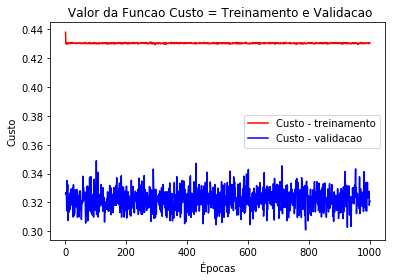

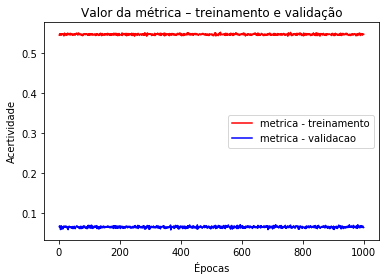

In [30]:
rna1.train(x_train_norm,y_train,x_val_norm,y_val,batch_size,epochs,loss,metric)
rna1.plot()

Confusion matrix, without normalization
[[25249  1736]
 [ 1616  1399]]


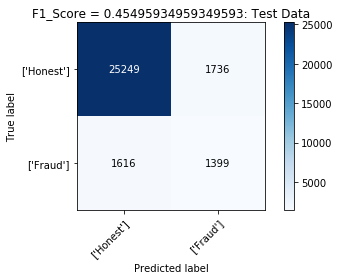

Confusion matrix, without normalization
[[25250  1736]
 [ 1588  1427]]


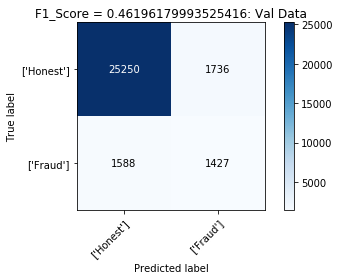

Confusion matrix, without normalization
[[117933   7998]
 [ 22413  19791]]


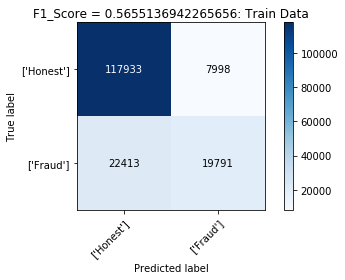

In [31]:
rna1.predict(x_data,y_data)

In [32]:
n_list2 = [50,50,1]
activation_list2 = ['tanh','tanh','sigmoid']
dropout_list2 = [0.1,0.1]

In [33]:
rna2 = new_rna()
rna2.build_model(data_shape,n_list2,activation_list2,dropout_list2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                10050     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 12,651
Trainable params: 12,651
Non-trainable params: 0
_________________________________________________________________


Train on 168135 samples, validate on 30001 samples
Epoch 1/1000
168135/168135 [==============================] - 8s 50us/step - loss: 0.4580 - f1: 0.5440 - val_loss: 0.3208 - val_f1: 0.0655
Epoch 2/1000
168135/168135 [==============================] - 8s 48us/step - loss: 0.4356 - f1: 0.5473 - val_loss: 0.3450 - val_f1: 0.0655
Epoch 3/1000
168135/168135 [==============================] - 8s 48us/step - loss: 0.4348 - f1: 0.5473 - val_loss: 0.3587 - val_f1: 0.0692
Epoch 4/1000
168135/168135 [==============================] - 8s 48us/step - loss: 0.4351 - f1: 0.5450 - val_loss: 0.3332 - val_f1: 0.0690
Epoch 5/1000
168135/168135 [==============================] - 8s 47us/step - loss: 0.4343 - f1: 0.5485 - val_loss: 0.3052 - val_f1: 0.0618
Epoch 6/1000
168135/168135 [==============================] - 8s 48us/step - loss: 0.4354 - f1: 0.5419 - val_loss: 0.3218 - val_f1: 0.0687
Epoch 7/1000
168135/168135 [==============================] - 8s 47us/step - loss: 0.4345 - f1: 0.5488 - val_loss: 

168135/168135 [==============================] - 8s 49us/step - loss: 0.4349 - f1: 0.5473 - val_loss: 0.3149 - val_f1: 0.0636
Epoch 60/1000
168135/168135 [==============================] - 8s 48us/step - loss: 0.4353 - f1: 0.5468 - val_loss: 0.3171 - val_f1: 0.0665
Epoch 61/1000
168135/168135 [==============================] - 8s 50us/step - loss: 0.4352 - f1: 0.5468 - val_loss: 0.3201 - val_f1: 0.0637
Epoch 62/1000
168135/168135 [==============================] - 8s 48us/step - loss: 0.4348 - f1: 0.5467 - val_loss: 0.3340 - val_f1: 0.0661
Epoch 63/1000
168135/168135 [==============================] - 8s 50us/step - loss: 0.4347 - f1: 0.5458 - val_loss: 0.3263 - val_f1: 0.0626
Epoch 64/1000
168135/168135 [==============================] - 8s 48us/step - loss: 0.4348 - f1: 0.5461 - val_loss: 0.3202 - val_f1: 0.0642
Epoch 65/1000
168135/168135 [==============================] - 8s 49us/step - loss: 0.4346 - f1: 0.5462 - val_loss: 0.3495 - val_f1: 0.0625
Epoch 66/1000
168135/168135 [=====

168135/168135 [==============================] - 8s 50us/step - loss: 0.4346 - f1: 0.5476 - val_loss: 0.3322 - val_f1: 0.0679
Epoch 118/1000
168135/168135 [==============================] - 8s 49us/step - loss: 0.4346 - f1: 0.5457 - val_loss: 0.3266 - val_f1: 0.0655
Epoch 119/1000
168135/168135 [==============================] - 8s 50us/step - loss: 0.4347 - f1: 0.5453 - val_loss: 0.3288 - val_f1: 0.0679
Epoch 120/1000
168135/168135 [==============================] - 8s 49us/step - loss: 0.4352 - f1: 0.5422 - val_loss: 0.3097 - val_f1: 0.0596
Epoch 121/1000
168135/168135 [==============================] - 9s 51us/step - loss: 0.4350 - f1: 0.5447 - val_loss: 0.3131 - val_f1: 0.0593
Epoch 122/1000
168135/168135 [==============================] - 8s 49us/step - loss: 0.4348 - f1: 0.5459 - val_loss: 0.3271 - val_f1: 0.0608
Epoch 123/1000
168135/168135 [==============================] - 8s 50us/step - loss: 0.4348 - f1: 0.5470 - val_loss: 0.3379 - val_f1: 0.0672
Epoch 124/1000
168135/168135

168135/168135 [==============================] - 8s 50us/step - loss: 0.4351 - f1: 0.5442 - val_loss: 0.3178 - val_f1: 0.0651
Epoch 176/1000
168135/168135 [==============================] - 8s 49us/step - loss: 0.4352 - f1: 0.5442 - val_loss: 0.3471 - val_f1: 0.0715
Epoch 177/1000
168135/168135 [==============================] - 8s 50us/step - loss: 0.4345 - f1: 0.5493 - val_loss: 0.3260 - val_f1: 0.0630
Epoch 178/1000
168135/168135 [==============================] - 8s 49us/step - loss: 0.4347 - f1: 0.5460 - val_loss: 0.3137 - val_f1: 0.0647
Epoch 179/1000
168135/168135 [==============================] - 9s 51us/step - loss: 0.4349 - f1: 0.5472 - val_loss: 0.3537 - val_f1: 0.0713
Epoch 180/1000
168135/168135 [==============================] - 8s 50us/step - loss: 0.4349 - f1: 0.5463 - val_loss: 0.3102 - val_f1: 0.0627
Epoch 181/1000
168135/168135 [==============================] - 8s 50us/step - loss: 0.4352 - f1: 0.5474 - val_loss: 0.3299 - val_f1: 0.0675
Epoch 182/1000
168135/168135

168135/168135 [==============================] - 8s 49us/step - loss: 0.4352 - f1: 0.5438 - val_loss: 0.3136 - val_f1: 0.0626
Epoch 234/1000
168135/168135 [==============================] - 9s 51us/step - loss: 0.4354 - f1: 0.5448 - val_loss: 0.3080 - val_f1: 0.0635
Epoch 235/1000
168135/168135 [==============================] - 8s 49us/step - loss: 0.4352 - f1: 0.5447 - val_loss: 0.3098 - val_f1: 0.0657
Epoch 236/1000
168135/168135 [==============================] - 9s 51us/step - loss: 0.4346 - f1: 0.5454 - val_loss: 0.3273 - val_f1: 0.0678
Epoch 237/1000
168135/168135 [==============================] - 8s 49us/step - loss: 0.4349 - f1: 0.5458 - val_loss: 0.3697 - val_f1: 0.0736
Epoch 238/1000
168135/168135 [==============================] - 8s 50us/step - loss: 0.4355 - f1: 0.5442 - val_loss: 0.3266 - val_f1: 0.0649
Epoch 239/1000
168135/168135 [==============================] - 8s 49us/step - loss: 0.4350 - f1: 0.5464 - val_loss: 0.3339 - val_f1: 0.0684
Epoch 240/1000
168135/168135

168135/168135 [==============================] - 9s 51us/step - loss: 0.4351 - f1: 0.5463 - val_loss: 0.3149 - val_f1: 0.0636
Epoch 292/1000
168135/168135 [==============================] - 8s 49us/step - loss: 0.4351 - f1: 0.5445 - val_loss: 0.3306 - val_f1: 0.0695
Epoch 293/1000
168135/168135 [==============================] - 8s 50us/step - loss: 0.4352 - f1: 0.5447 - val_loss: 0.3216 - val_f1: 0.0651
Epoch 294/1000
168135/168135 [==============================] - 8s 50us/step - loss: 0.4349 - f1: 0.5462 - val_loss: 0.3107 - val_f1: 0.0593
Epoch 295/1000
168135/168135 [==============================] - 8s 50us/step - loss: 0.4349 - f1: 0.5447 - val_loss: 0.3015 - val_f1: 0.0638
Epoch 296/1000
168135/168135 [==============================] - 8s 49us/step - loss: 0.4353 - f1: 0.5434 - val_loss: 0.3293 - val_f1: 0.0619
Epoch 297/1000
168135/168135 [==============================] - 8s 51us/step - loss: 0.4351 - f1: 0.5469 - val_loss: 0.3447 - val_f1: 0.0687
Epoch 298/1000
168135/168135

168135/168135 [==============================] - 9s 51us/step - loss: 0.4349 - f1: 0.5443 - val_loss: 0.3178 - val_f1: 0.0650
Epoch 350/1000
168135/168135 [==============================] - 8s 49us/step - loss: 0.4354 - f1: 0.5442 - val_loss: 0.3394 - val_f1: 0.0698
Epoch 351/1000
168135/168135 [==============================] - 9s 51us/step - loss: 0.4347 - f1: 0.5487 - val_loss: 0.3273 - val_f1: 0.0667
Epoch 352/1000
168135/168135 [==============================] - 8s 50us/step - loss: 0.4347 - f1: 0.5469 - val_loss: 0.3084 - val_f1: 0.0651
Epoch 353/1000
168135/168135 [==============================] - 8s 50us/step - loss: 0.4344 - f1: 0.5460 - val_loss: 0.3016 - val_f1: 0.0613
Epoch 354/1000
168135/168135 [==============================] - 9s 51us/step - loss: 0.4351 - f1: 0.5443 - val_loss: 0.3437 - val_f1: 0.0639
Epoch 355/1000
168135/168135 [==============================] - 8s 49us/step - loss: 0.4349 - f1: 0.5453 - val_loss: 0.3162 - val_f1: 0.0642
Epoch 356/1000
168135/168135

168135/168135 [==============================] - 8s 50us/step - loss: 0.4346 - f1: 0.5453 - val_loss: 0.3320 - val_f1: 0.0670
Epoch 408/1000
168135/168135 [==============================] - 8s 50us/step - loss: 0.4350 - f1: 0.5460 - val_loss: 0.3422 - val_f1: 0.0707
Epoch 409/1000
168135/168135 [==============================] - 8s 50us/step - loss: 0.4353 - f1: 0.5450 - val_loss: 0.3539 - val_f1: 0.0719
Epoch 410/1000
168135/168135 [==============================] - 8s 50us/step - loss: 0.4353 - f1: 0.5445 - val_loss: 0.3078 - val_f1: 0.0642
Epoch 411/1000
168135/168135 [==============================] - 8s 49us/step - loss: 0.4350 - f1: 0.5446 - val_loss: 0.2990 - val_f1: 0.0603
Epoch 412/1000
168135/168135 [==============================] - 9s 52us/step - loss: 0.4346 - f1: 0.5465 - val_loss: 0.3395 - val_f1: 0.0665
Epoch 413/1000
168135/168135 [==============================] - 8s 50us/step - loss: 0.4353 - f1: 0.5428 - val_loss: 0.3037 - val_f1: 0.0586
Epoch 414/1000
168135/168135

168135/168135 [==============================] - 9s 51us/step - loss: 0.4348 - f1: 0.5451 - val_loss: 0.3204 - val_f1: 0.0657
Epoch 466/1000
168135/168135 [==============================] - 8s 49us/step - loss: 0.4347 - f1: 0.5461 - val_loss: 0.3294 - val_f1: 0.0648
Epoch 467/1000
168135/168135 [==============================] - 9s 51us/step - loss: 0.4348 - f1: 0.5462 - val_loss: 0.3432 - val_f1: 0.0698
Epoch 468/1000
168135/168135 [==============================] - 8s 50us/step - loss: 0.4355 - f1: 0.5448 - val_loss: 0.3427 - val_f1: 0.0712
Epoch 469/1000
168135/168135 [==============================] - 8s 50us/step - loss: 0.4351 - f1: 0.5471 - val_loss: 0.3230 - val_f1: 0.0641
Epoch 470/1000
168135/168135 [==============================] - 8s 49us/step - loss: 0.4347 - f1: 0.5427 - val_loss: 0.3251 - val_f1: 0.0658
Epoch 471/1000
168135/168135 [==============================] - 9s 51us/step - loss: 0.4349 - f1: 0.5455 - val_loss: 0.3180 - val_f1: 0.0646
Epoch 472/1000
168135/168135

168135/168135 [==============================] - 8s 50us/step - loss: 0.4347 - f1: 0.5454 - val_loss: 0.3254 - val_f1: 0.0659
Epoch 524/1000
168135/168135 [==============================] - 9s 51us/step - loss: 0.4350 - f1: 0.5462 - val_loss: 0.3300 - val_f1: 0.0616
Epoch 525/1000
168135/168135 [==============================] - 8s 50us/step - loss: 0.4347 - f1: 0.5493 - val_loss: 0.3414 - val_f1: 0.0697
Epoch 526/1000
168135/168135 [==============================] - 8s 50us/step - loss: 0.4347 - f1: 0.5464 - val_loss: 0.3305 - val_f1: 0.0689
Epoch 527/1000
168135/168135 [==============================] - 8s 50us/step - loss: 0.4352 - f1: 0.5436 - val_loss: 0.3245 - val_f1: 0.0622
Epoch 528/1000
168135/168135 [==============================] - 8s 50us/step - loss: 0.4347 - f1: 0.5441 - val_loss: 0.3118 - val_f1: 0.0661
Epoch 529/1000
168135/168135 [==============================] - 8s 50us/step - loss: 0.4349 - f1: 0.5450 - val_loss: 0.3251 - val_f1: 0.0662
Epoch 530/1000
168135/168135

168135/168135 [==============================] - 9s 51us/step - loss: 0.4349 - f1: 0.5468 - val_loss: 0.3553 - val_f1: 0.0731
Epoch 582/1000
168135/168135 [==============================] - 8s 50us/step - loss: 0.4347 - f1: 0.5488 - val_loss: 0.3153 - val_f1: 0.0648
Epoch 583/1000
168135/168135 [==============================] - 8s 51us/step - loss: 0.4350 - f1: 0.5454 - val_loss: 0.3216 - val_f1: 0.0664
Epoch 584/1000
168135/168135 [==============================] - 8s 49us/step - loss: 0.4354 - f1: 0.5464 - val_loss: 0.3389 - val_f1: 0.0678
Epoch 585/1000
168135/168135 [==============================] - 8s 50us/step - loss: 0.4349 - f1: 0.5453 - val_loss: 0.3153 - val_f1: 0.0625
Epoch 586/1000
168135/168135 [==============================] - 8s 49us/step - loss: 0.4349 - f1: 0.5451 - val_loss: 0.3304 - val_f1: 0.0676
Epoch 587/1000
168135/168135 [==============================] - 9s 51us/step - loss: 0.4348 - f1: 0.5464 - val_loss: 0.3318 - val_f1: 0.0676
Epoch 588/1000
168135/168135

168135/168135 [==============================] - 8s 50us/step - loss: 0.4351 - f1: 0.5471 - val_loss: 0.3301 - val_f1: 0.0687
Epoch 640/1000
168135/168135 [==============================] - 8s 50us/step - loss: 0.4349 - f1: 0.5460 - val_loss: 0.3301 - val_f1: 0.0632
Epoch 641/1000
168135/168135 [==============================] - 8s 49us/step - loss: 0.4351 - f1: 0.5444 - val_loss: 0.3300 - val_f1: 0.0704
Epoch 642/1000
168135/168135 [==============================] - 8s 50us/step - loss: 0.4354 - f1: 0.5452 - val_loss: 0.3228 - val_f1: 0.0656
Epoch 643/1000
168135/168135 [==============================] - 8s 49us/step - loss: 0.4348 - f1: 0.5462 - val_loss: 0.3070 - val_f1: 0.0621
Epoch 644/1000
168135/168135 [==============================] - 8s 50us/step - loss: 0.4350 - f1: 0.5460 - val_loss: 0.3247 - val_f1: 0.0641
Epoch 645/1000
168135/168135 [==============================] - 8s 49us/step - loss: 0.4348 - f1: 0.5464 - val_loss: 0.3327 - val_f1: 0.0658
Epoch 646/1000
168135/168135

168135/168135 [==============================] - 9s 51us/step - loss: 0.4349 - f1: 0.5451 - val_loss: 0.3504 - val_f1: 0.0703
Epoch 698/1000
168135/168135 [==============================] - 8s 49us/step - loss: 0.4343 - f1: 0.5471 - val_loss: 0.3171 - val_f1: 0.0642
Epoch 699/1000
168135/168135 [==============================] - 8s 50us/step - loss: 0.4353 - f1: 0.5435 - val_loss: 0.3185 - val_f1: 0.0670
Epoch 700/1000
168135/168135 [==============================] - 8s 49us/step - loss: 0.4351 - f1: 0.5442 - val_loss: 0.3288 - val_f1: 0.0645
Epoch 701/1000
168135/168135 [==============================] - 8s 50us/step - loss: 0.4349 - f1: 0.5462 - val_loss: 0.3297 - val_f1: 0.0691
Epoch 702/1000
168135/168135 [==============================] - 8s 49us/step - loss: 0.4350 - f1: 0.5448 - val_loss: 0.3246 - val_f1: 0.0651
Epoch 703/1000
168135/168135 [==============================] - 8s 50us/step - loss: 0.4349 - f1: 0.5474 - val_loss: 0.3331 - val_f1: 0.0705
Epoch 704/1000
168135/168135

168135/168135 [==============================] - 8s 49us/step - loss: 0.4350 - f1: 0.5466 - val_loss: 0.3292 - val_f1: 0.0649
Epoch 756/1000
168135/168135 [==============================] - 8s 50us/step - loss: 0.4345 - f1: 0.5457 - val_loss: 0.3392 - val_f1: 0.0695
Epoch 757/1000
168135/168135 [==============================] - 8s 49us/step - loss: 0.4351 - f1: 0.5456 - val_loss: 0.3109 - val_f1: 0.0588
Epoch 758/1000
168135/168135 [==============================] - 8s 51us/step - loss: 0.4350 - f1: 0.5479 - val_loss: 0.3407 - val_f1: 0.0664
Epoch 759/1000
168135/168135 [==============================] - 8s 49us/step - loss: 0.4352 - f1: 0.5458 - val_loss: 0.3176 - val_f1: 0.0650
Epoch 760/1000
168135/168135 [==============================] - 8s 49us/step - loss: 0.4348 - f1: 0.5480 - val_loss: 0.3267 - val_f1: 0.0641
Epoch 761/1000
168135/168135 [==============================] - 9s 51us/step - loss: 0.4344 - f1: 0.5464 - val_loss: 0.3440 - val_f1: 0.0706
Epoch 762/1000
168135/168135

168135/168135 [==============================] - 8s 50us/step - loss: 0.4352 - f1: 0.5453 - val_loss: 0.3199 - val_f1: 0.0602
Epoch 814/1000
168135/168135 [==============================] - 8s 49us/step - loss: 0.4342 - f1: 0.5477 - val_loss: 0.3167 - val_f1: 0.0632
Epoch 815/1000
168135/168135 [==============================] - 8s 50us/step - loss: 0.4347 - f1: 0.5456 - val_loss: 0.3242 - val_f1: 0.0603
Epoch 816/1000
168135/168135 [==============================] - 8s 50us/step - loss: 0.4350 - f1: 0.5470 - val_loss: 0.3198 - val_f1: 0.0661
Epoch 817/1000
168135/168135 [==============================] - 8s 50us/step - loss: 0.4353 - f1: 0.5453 - val_loss: 0.3214 - val_f1: 0.0647
Epoch 818/1000
168135/168135 [==============================] - 8s 49us/step - loss: 0.4345 - f1: 0.5438 - val_loss: 0.3310 - val_f1: 0.0655
Epoch 819/1000
168135/168135 [==============================] - 9s 51us/step - loss: 0.4345 - f1: 0.5444 - val_loss: 0.3148 - val_f1: 0.0641
Epoch 820/1000
168135/168135

168135/168135 [==============================] - 8s 50us/step - loss: 0.4350 - f1: 0.5447 - val_loss: 0.3284 - val_f1: 0.0692
Epoch 872/1000
168135/168135 [==============================] - 8s 50us/step - loss: 0.4350 - f1: 0.5467 - val_loss: 0.3226 - val_f1: 0.0640
Epoch 873/1000
168135/168135 [==============================] - 8s 50us/step - loss: 0.4352 - f1: 0.5463 - val_loss: 0.3316 - val_f1: 0.0678
Epoch 874/1000
168135/168135 [==============================] - 8s 50us/step - loss: 0.4350 - f1: 0.5453 - val_loss: 0.3199 - val_f1: 0.0618
Epoch 875/1000
168135/168135 [==============================] - 8s 49us/step - loss: 0.4354 - f1: 0.5432 - val_loss: 0.3064 - val_f1: 0.0618
Epoch 876/1000
168135/168135 [==============================] - 9s 51us/step - loss: 0.4350 - f1: 0.5476 - val_loss: 0.3239 - val_f1: 0.0635
Epoch 877/1000
168135/168135 [==============================] - 8s 49us/step - loss: 0.4347 - f1: 0.5486 - val_loss: 0.3249 - val_f1: 0.0590
Epoch 878/1000
168135/168135

168135/168135 [==============================] - 8s 50us/step - loss: 0.4355 - f1: 0.5458 - val_loss: 0.3521 - val_f1: 0.0706
Epoch 930/1000
168135/168135 [==============================] - 8s 50us/step - loss: 0.4347 - f1: 0.5453 - val_loss: 0.3376 - val_f1: 0.0709
Epoch 931/1000
168135/168135 [==============================] - 8s 51us/step - loss: 0.4353 - f1: 0.5471 - val_loss: 0.3271 - val_f1: 0.0689
Epoch 932/1000
168135/168135 [==============================] - 8s 50us/step - loss: 0.4353 - f1: 0.5466 - val_loss: 0.3386 - val_f1: 0.0669
Epoch 933/1000
168135/168135 [==============================] - 8s 50us/step - loss: 0.4351 - f1: 0.5467 - val_loss: 0.3107 - val_f1: 0.0605
Epoch 934/1000
168135/168135 [==============================] - 8s 50us/step - loss: 0.4350 - f1: 0.5447 - val_loss: 0.3430 - val_f1: 0.0687
Epoch 935/1000
168135/168135 [==============================] - 8s 50us/step - loss: 0.4350 - f1: 0.5474 - val_loss: 0.3325 - val_f1: 0.0671
Epoch 936/1000
168135/168135

168135/168135 [==============================] - 8s 50us/step - loss: 0.4351 - f1: 0.5441 - val_loss: 0.3282 - val_f1: 0.0670
Epoch 988/1000
168135/168135 [==============================] - 8s 49us/step - loss: 0.4350 - f1: 0.5489 - val_loss: 0.3245 - val_f1: 0.0677
Epoch 989/1000
168135/168135 [==============================] - 8s 50us/step - loss: 0.4350 - f1: 0.5446 - val_loss: 0.3594 - val_f1: 0.0728
Epoch 990/1000
168135/168135 [==============================] - 8s 49us/step - loss: 0.4351 - f1: 0.5462 - val_loss: 0.3215 - val_f1: 0.0630
Epoch 991/1000
168135/168135 [==============================] - 8s 50us/step - loss: 0.4352 - f1: 0.5441 - val_loss: 0.3326 - val_f1: 0.0617
Epoch 992/1000
168135/168135 [==============================] - 8s 50us/step - loss: 0.4343 - f1: 0.5477 - val_loss: 0.3322 - val_f1: 0.0673
Epoch 993/1000
168135/168135 [==============================] - 9s 51us/step - loss: 0.4347 - f1: 0.5457 - val_loss: 0.3376 - val_f1: 0.0709
Epoch 994/1000
168135/168135

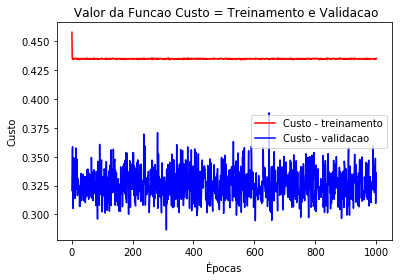

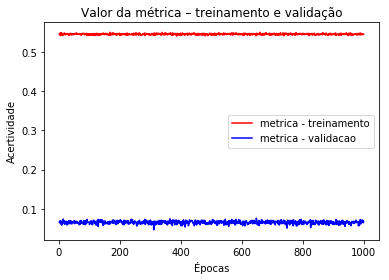

In [34]:
rna2.train(x_train_norm,y_train,x_val_norm,y_val,batch_size,epochs,loss,metric)
rna2.plot()

Confusion matrix, without normalization
[[24983  2002]
 [ 1499  1516]]


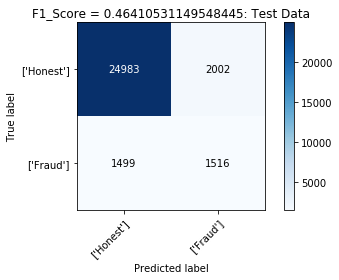

Confusion matrix, without normalization
[[24979  2007]
 [ 1514  1501]]


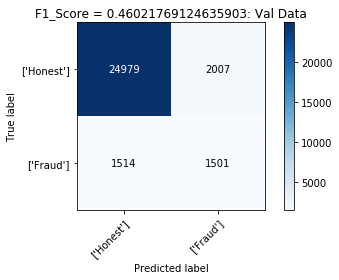

Confusion matrix, without normalization
[[116675   9256]
 [ 20829  21375]]


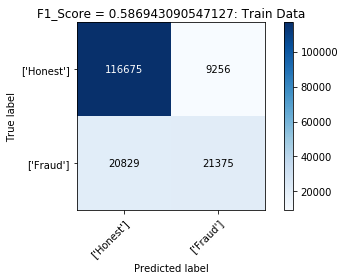

In [35]:
rna2.predict(x_data,y_data)

In [36]:
n_list3 = [100,100,1]
activation_list3 = ['tanh', 'tanh', 'sigmoid']
dropout_list3 = [0.1,0.1]

In [37]:
rna3 = new_rna()
rna3.build_model(data_shape,n_list3,activation_list3,dropout_list3)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 30,301
Trainable params: 30,301
Non-trainable params: 0
_________________________________________________________________


Train on 168135 samples, validate on 30001 samples
Epoch 1/1000
168135/168135 [==============================] - 11s 66us/step - loss: 0.4797 - f1: 0.5448 - val_loss: 0.3222 - val_f1: 0.0683
Epoch 2/1000
168135/168135 [==============================] - 10s 60us/step - loss: 0.4351 - f1: 0.5442 - val_loss: 0.3142 - val_f1: 0.0625
Epoch 3/1000
168135/168135 [==============================] - 10s 60us/step - loss: 0.4349 - f1: 0.5443 - val_loss: 0.3209 - val_f1: 0.0640
Epoch 4/1000
168135/168135 [==============================] - 10s 62us/step - loss: 0.4347 - f1: 0.5460 - val_loss: 0.3418 - val_f1: 0.0706
Epoch 5/1000
168135/168135 [==============================] - 10s 60us/step - loss: 0.4348 - f1: 0.5449 - val_loss: 0.3320 - val_f1: 0.0668
Epoch 6/1000
168135/168135 [==============================] - 10s 61us/step - loss: 0.4348 - f1: 0.5438 - val_loss: 0.3329 - val_f1: 0.0673
Epoch 7/1000
168135/168135 [==============================] - 10s 59us/step - loss: 0.4346 - f1: 0.5427 - val

Epoch 59/1000
168135/168135 [==============================] - 10s 61us/step - loss: 0.4349 - f1: 0.5440 - val_loss: 0.3128 - val_f1: 0.0608
Epoch 60/1000
168135/168135 [==============================] - 10s 60us/step - loss: 0.4347 - f1: 0.5425 - val_loss: 0.3025 - val_f1: 0.0584
Epoch 61/1000
168135/168135 [==============================] - 10s 61us/step - loss: 0.4350 - f1: 0.5452 - val_loss: 0.3387 - val_f1: 0.0669
Epoch 62/1000
168135/168135 [==============================] - 10s 60us/step - loss: 0.4348 - f1: 0.5442 - val_loss: 0.3435 - val_f1: 0.0704
Epoch 63/1000
168135/168135 [==============================] - 10s 61us/step - loss: 0.4343 - f1: 0.5452 - val_loss: 0.3180 - val_f1: 0.0613
Epoch 64/1000
168135/168135 [==============================] - 10s 61us/step - loss: 0.4348 - f1: 0.5454 - val_loss: 0.3436 - val_f1: 0.0687
Epoch 65/1000
168135/168135 [==============================] - 10s 59us/step - loss: 0.4348 - f1: 0.5465 - val_loss: 0.3535 - val_f1: 0.0710
Epoch 66/1000

Epoch 117/1000
168135/168135 [==============================] - 10s 60us/step - loss: 0.4343 - f1: 0.5456 - val_loss: 0.3426 - val_f1: 0.0702
Epoch 118/1000
168135/168135 [==============================] - 10s 60us/step - loss: 0.4345 - f1: 0.5467 - val_loss: 0.3134 - val_f1: 0.0617
Epoch 119/1000
168135/168135 [==============================] - 10s 61us/step - loss: 0.4347 - f1: 0.5444 - val_loss: 0.3260 - val_f1: 0.0655
Epoch 120/1000
168135/168135 [==============================] - 10s 60us/step - loss: 0.4339 - f1: 0.5440 - val_loss: 0.3217 - val_f1: 0.0675
Epoch 121/1000
168135/168135 [==============================] - 10s 61us/step - loss: 0.4351 - f1: 0.5422 - val_loss: 0.3155 - val_f1: 0.0647
Epoch 122/1000
168135/168135 [==============================] - 10s 60us/step - loss: 0.4343 - f1: 0.5443 - val_loss: 0.3248 - val_f1: 0.0684
Epoch 123/1000
168135/168135 [==============================] - 10s 60us/step - loss: 0.4346 - f1: 0.5428 - val_loss: 0.3135 - val_f1: 0.0627
Epoch 

168135/168135 [==============================] - 10s 60us/step - loss: 0.4347 - f1: 0.5458 - val_loss: 0.3329 - val_f1: 0.0677
Epoch 175/1000
168135/168135 [==============================] - 10s 60us/step - loss: 0.4346 - f1: 0.5443 - val_loss: 0.3128 - val_f1: 0.0619
Epoch 176/1000
168135/168135 [==============================] - 10s 61us/step - loss: 0.4343 - f1: 0.5434 - val_loss: 0.3585 - val_f1: 0.0715
Epoch 177/1000
168135/168135 [==============================] - 10s 60us/step - loss: 0.4347 - f1: 0.5469 - val_loss: 0.3126 - val_f1: 0.0624
Epoch 178/1000
168135/168135 [==============================] - 10s 61us/step - loss: 0.4344 - f1: 0.5456 - val_loss: 0.3190 - val_f1: 0.0645
Epoch 179/1000
168135/168135 [==============================] - 10s 61us/step - loss: 0.4351 - f1: 0.5399 - val_loss: 0.3166 - val_f1: 0.0645
Epoch 180/1000
168135/168135 [==============================] - 10s 60us/step - loss: 0.4343 - f1: 0.5456 - val_loss: 0.3123 - val_f1: 0.0605
Epoch 181/1000
168135

Epoch 232/1000
168135/168135 [==============================] - 10s 59us/step - loss: 0.4350 - f1: 0.5446 - val_loss: 0.3271 - val_f1: 0.0682
Epoch 233/1000
168135/168135 [==============================] - 10s 61us/step - loss: 0.4343 - f1: 0.5463 - val_loss: 0.3404 - val_f1: 0.0698
Epoch 234/1000
168135/168135 [==============================] - 10s 60us/step - loss: 0.4347 - f1: 0.5454 - val_loss: 0.3010 - val_f1: 0.0615
Epoch 235/1000
168135/168135 [==============================] - 10s 60us/step - loss: 0.4344 - f1: 0.5442 - val_loss: 0.3309 - val_f1: 0.0663
Epoch 236/1000
168135/168135 [==============================] - 10s 61us/step - loss: 0.4346 - f1: 0.5465 - val_loss: 0.3292 - val_f1: 0.0645
Epoch 237/1000
168135/168135 [==============================] - 10s 60us/step - loss: 0.4347 - f1: 0.5417 - val_loss: 0.3191 - val_f1: 0.0632
Epoch 238/1000
168135/168135 [==============================] - 10s 61us/step - loss: 0.4345 - f1: 0.5431 - val_loss: 0.3356 - val_f1: 0.0717
Epoch 

168135/168135 [==============================] - 10s 60us/step - loss: 0.4343 - f1: 0.5488 - val_loss: 0.3089 - val_f1: 0.0609
Epoch 290/1000
168135/168135 [==============================] - 10s 61us/step - loss: 0.4346 - f1: 0.5456 - val_loss: 0.3357 - val_f1: 0.0709
Epoch 291/1000
168135/168135 [==============================] - 10s 61us/step - loss: 0.4345 - f1: 0.5440 - val_loss: 0.3155 - val_f1: 0.0603
Epoch 292/1000
168135/168135 [==============================] - 10s 59us/step - loss: 0.4344 - f1: 0.5459 - val_loss: 0.3408 - val_f1: 0.0691
Epoch 293/1000
168135/168135 [==============================] - 10s 61us/step - loss: 0.4347 - f1: 0.5448 - val_loss: 0.3152 - val_f1: 0.0635
Epoch 294/1000
168135/168135 [==============================] - 10s 60us/step - loss: 0.4349 - f1: 0.5412 - val_loss: 0.3094 - val_f1: 0.0616
Epoch 295/1000
168135/168135 [==============================] - 10s 60us/step - loss: 0.4344 - f1: 0.5464 - val_loss: 0.3131 - val_f1: 0.0615
Epoch 296/1000
168135

Epoch 347/1000
168135/168135 [==============================] - 10s 59us/step - loss: 0.4346 - f1: 0.5434 - val_loss: 0.3142 - val_f1: 0.0636
Epoch 348/1000
168135/168135 [==============================] - 10s 61us/step - loss: 0.4346 - f1: 0.5459 - val_loss: 0.3090 - val_f1: 0.0582
Epoch 349/1000
168135/168135 [==============================] - 10s 62us/step - loss: 0.4350 - f1: 0.5459 - val_loss: 0.3322 - val_f1: 0.0689
Epoch 350/1000
168135/168135 [==============================] - 10s 60us/step - loss: 0.4344 - f1: 0.5422 - val_loss: 0.3385 - val_f1: 0.0680
Epoch 351/1000
168135/168135 [==============================] - 10s 60us/step - loss: 0.4348 - f1: 0.5421 - val_loss: 0.3388 - val_f1: 0.0692
Epoch 352/1000
168135/168135 [==============================] - 10s 60us/step - loss: 0.4344 - f1: 0.5465 - val_loss: 0.3079 - val_f1: 0.0579
Epoch 353/1000
168135/168135 [==============================] - 10s 61us/step - loss: 0.4345 - f1: 0.5464 - val_loss: 0.3335 - val_f1: 0.0683
Epoch 

168135/168135 [==============================] - 10s 59us/step - loss: 0.4346 - f1: 0.5464 - val_loss: 0.3236 - val_f1: 0.0622
Epoch 405/1000
168135/168135 [==============================] - 10s 61us/step - loss: 0.4341 - f1: 0.5449 - val_loss: 0.3134 - val_f1: 0.0632
Epoch 406/1000
168135/168135 [==============================] - 10s 61us/step - loss: 0.4346 - f1: 0.5451 - val_loss: 0.3144 - val_f1: 0.0641
Epoch 407/1000
168135/168135 [==============================] - 10s 59us/step - loss: 0.4351 - f1: 0.5445 - val_loss: 0.3296 - val_f1: 0.0645
Epoch 408/1000
168135/168135 [==============================] - 10s 60us/step - loss: 0.4349 - f1: 0.5437 - val_loss: 0.3218 - val_f1: 0.0588
Epoch 409/1000
168135/168135 [==============================] - 10s 61us/step - loss: 0.4344 - f1: 0.5436 - val_loss: 0.3209 - val_f1: 0.0687
Epoch 410/1000
168135/168135 [==============================] - 10s 59us/step - loss: 0.4351 - f1: 0.5442 - val_loss: 0.3148 - val_f1: 0.0638
Epoch 411/1000
168135

Epoch 462/1000
168135/168135 [==============================] - 10s 61us/step - loss: 0.4348 - f1: 0.5447 - val_loss: 0.3179 - val_f1: 0.0633
Epoch 463/1000
168135/168135 [==============================] - 10s 61us/step - loss: 0.4349 - f1: 0.5465 - val_loss: 0.3231 - val_f1: 0.0644
Epoch 464/1000
168135/168135 [==============================] - 10s 60us/step - loss: 0.4350 - f1: 0.5429 - val_loss: 0.3695 - val_f1: 0.0722
Epoch 465/1000
168135/168135 [==============================] - 10s 61us/step - loss: 0.4347 - f1: 0.5422 - val_loss: 0.3067 - val_f1: 0.0630
Epoch 466/1000
168135/168135 [==============================] - 10s 59us/step - loss: 0.4346 - f1: 0.5418 - val_loss: 0.3271 - val_f1: 0.0660
Epoch 467/1000
168135/168135 [==============================] - 10s 61us/step - loss: 0.4347 - f1: 0.5452 - val_loss: 0.3432 - val_f1: 0.0665
Epoch 468/1000
168135/168135 [==============================] - 10s 61us/step - loss: 0.4345 - f1: 0.5453 - val_loss: 0.3348 - val_f1: 0.0699
Epoch 

168135/168135 [==============================] - 10s 61us/step - loss: 0.4349 - f1: 0.5452 - val_loss: 0.3472 - val_f1: 0.0657
Epoch 520/1000
168135/168135 [==============================] - 10s 60us/step - loss: 0.4345 - f1: 0.5443 - val_loss: 0.3371 - val_f1: 0.0698
Epoch 521/1000
168135/168135 [==============================] - 10s 59us/step - loss: 0.4351 - f1: 0.5433 - val_loss: 0.3312 - val_f1: 0.0682
Epoch 522/1000
168135/168135 [==============================] - 10s 61us/step - loss: 0.4344 - f1: 0.5451 - val_loss: 0.3182 - val_f1: 0.0640
Epoch 523/1000
168135/168135 [==============================] - 10s 60us/step - loss: 0.4347 - f1: 0.5464 - val_loss: 0.3323 - val_f1: 0.0639
Epoch 524/1000
168135/168135 [==============================] - 10s 61us/step - loss: 0.4348 - f1: 0.5427 - val_loss: 0.3415 - val_f1: 0.0685
Epoch 525/1000
168135/168135 [==============================] - 10s 61us/step - loss: 0.4348 - f1: 0.5463 - val_loss: 0.3390 - val_f1: 0.0706
Epoch 526/1000
168135

Epoch 577/1000
168135/168135 [==============================] - 10s 60us/step - loss: 0.4348 - f1: 0.5446 - val_loss: 0.3107 - val_f1: 0.0607
Epoch 578/1000
168135/168135 [==============================] - 10s 61us/step - loss: 0.4349 - f1: 0.5447 - val_loss: 0.3358 - val_f1: 0.0693
Epoch 579/1000
168135/168135 [==============================] - 10s 60us/step - loss: 0.4347 - f1: 0.5448 - val_loss: 0.3288 - val_f1: 0.0667
Epoch 580/1000
168135/168135 [==============================] - 10s 59us/step - loss: 0.4351 - f1: 0.5453 - val_loss: 0.3272 - val_f1: 0.0622
Epoch 581/1000
168135/168135 [==============================] - 10s 61us/step - loss: 0.4344 - f1: 0.5457 - val_loss: 0.3309 - val_f1: 0.0687
Epoch 582/1000
168135/168135 [==============================] - 10s 60us/step - loss: 0.4351 - f1: 0.5440 - val_loss: 0.3009 - val_f1: 0.0615
Epoch 583/1000
168135/168135 [==============================] - 10s 60us/step - loss: 0.4341 - f1: 0.5469 - val_loss: 0.3253 - val_f1: 0.0657
Epoch 

168135/168135 [==============================] - 10s 59us/step - loss: 0.4350 - f1: 0.5433 - val_loss: 0.3301 - val_f1: 0.0650
Epoch 635/1000
168135/168135 [==============================] - 10s 62us/step - loss: 0.4347 - f1: 0.5449 - val_loss: 0.3098 - val_f1: 0.0622
Epoch 636/1000
168135/168135 [==============================] - 10s 61us/step - loss: 0.4349 - f1: 0.5450 - val_loss: 0.3413 - val_f1: 0.0718
Epoch 637/1000
168135/168135 [==============================] - 10s 60us/step - loss: 0.4350 - f1: 0.5459 - val_loss: 0.3346 - val_f1: 0.0644
Epoch 638/1000
168135/168135 [==============================] - 10s 60us/step - loss: 0.4346 - f1: 0.5453 - val_loss: 0.3380 - val_f1: 0.0662
Epoch 639/1000
168135/168135 [==============================] - 10s 60us/step - loss: 0.4344 - f1: 0.5469 - val_loss: 0.3072 - val_f1: 0.0617
Epoch 640/1000
168135/168135 [==============================] - 10s 61us/step - loss: 0.4349 - f1: 0.5434 - val_loss: 0.3374 - val_f1: 0.0674
Epoch 641/1000
168135

Epoch 692/1000
168135/168135 [==============================] - 10s 59us/step - loss: 0.4347 - f1: 0.5441 - val_loss: 0.3209 - val_f1: 0.0658
Epoch 693/1000
168135/168135 [==============================] - 10s 60us/step - loss: 0.4345 - f1: 0.5459 - val_loss: 0.3144 - val_f1: 0.0642
Epoch 694/1000
168135/168135 [==============================] - 10s 60us/step - loss: 0.4347 - f1: 0.5445 - val_loss: 0.3341 - val_f1: 0.0684
Epoch 695/1000
168135/168135 [==============================] - 10s 59us/step - loss: 0.4346 - f1: 0.5472 - val_loss: 0.3492 - val_f1: 0.0715
Epoch 696/1000
168135/168135 [==============================] - 11s 64us/step - loss: 0.4345 - f1: 0.5431 - val_loss: 0.3473 - val_f1: 0.0713
Epoch 697/1000
168135/168135 [==============================] - 10s 61us/step - loss: 0.4347 - f1: 0.5447 - val_loss: 0.3071 - val_f1: 0.0616
Epoch 698/1000
168135/168135 [==============================] - 10s 60us/step - loss: 0.4345 - f1: 0.5476 - val_loss: 0.3190 - val_f1: 0.0633
Epoch 

168135/168135 [==============================] - 10s 60us/step - loss: 0.4343 - f1: 0.5457 - val_loss: 0.3207 - val_f1: 0.0617
Epoch 750/1000
168135/168135 [==============================] - 10s 60us/step - loss: 0.4345 - f1: 0.5459 - val_loss: 0.3209 - val_f1: 0.0638
Epoch 751/1000
168135/168135 [==============================] - 10s 60us/step - loss: 0.4351 - f1: 0.5442 - val_loss: 0.3216 - val_f1: 0.0590
Epoch 752/1000
168135/168135 [==============================] - 10s 60us/step - loss: 0.4344 - f1: 0.5463 - val_loss: 0.3216 - val_f1: 0.0664
Epoch 753/1000
168135/168135 [==============================] - 10s 59us/step - loss: 0.4344 - f1: 0.5427 - val_loss: 0.3143 - val_f1: 0.0586
Epoch 754/1000
168135/168135 [==============================] - 10s 60us/step - loss: 0.4346 - f1: 0.5449 - val_loss: 0.3227 - val_f1: 0.0646
Epoch 755/1000
168135/168135 [==============================] - 10s 60us/step - loss: 0.4342 - f1: 0.5441 - val_loss: 0.3137 - val_f1: 0.0639
Epoch 756/1000
168135

Epoch 807/1000
168135/168135 [==============================] - 10s 59us/step - loss: 0.4345 - f1: 0.5440 - val_loss: 0.3236 - val_f1: 0.0658
Epoch 808/1000
168135/168135 [==============================] - 10s 59us/step - loss: 0.4351 - f1: 0.5421 - val_loss: 0.3207 - val_f1: 0.0659
Epoch 809/1000
168135/168135 [==============================] - 10s 60us/step - loss: 0.4350 - f1: 0.5432 - val_loss: 0.3238 - val_f1: 0.0661
Epoch 810/1000
168135/168135 [==============================] - 10s 61us/step - loss: 0.4346 - f1: 0.5458 - val_loss: 0.3321 - val_f1: 0.0682
Epoch 811/1000
168135/168135 [==============================] - 10s 60us/step - loss: 0.4348 - f1: 0.5430 - val_loss: 0.3243 - val_f1: 0.0640
Epoch 812/1000
168135/168135 [==============================] - 10s 59us/step - loss: 0.4346 - f1: 0.5452 - val_loss: 0.3217 - val_f1: 0.0657
Epoch 813/1000
168135/168135 [==============================] - 10s 60us/step - loss: 0.4347 - f1: 0.5456 - val_loss: 0.3296 - val_f1: 0.0631
Epoch 

168135/168135 [==============================] - 10s 61us/step - loss: 0.4343 - f1: 0.5480 - val_loss: 0.3117 - val_f1: 0.0621
Epoch 865/1000
168135/168135 [==============================] - 10s 60us/step - loss: 0.4346 - f1: 0.5456 - val_loss: 0.3209 - val_f1: 0.0663
Epoch 866/1000
168135/168135 [==============================] - 10s 61us/step - loss: 0.4349 - f1: 0.5411 - val_loss: 0.3049 - val_f1: 0.0578
Epoch 867/1000
168135/168135 [==============================] - 10s 61us/step - loss: 0.4342 - f1: 0.5456 - val_loss: 0.3238 - val_f1: 0.0666
Epoch 868/1000
168135/168135 [==============================] - 10s 59us/step - loss: 0.4348 - f1: 0.5438 - val_loss: 0.3296 - val_f1: 0.0670
Epoch 869/1000
168135/168135 [==============================] - 10s 61us/step - loss: 0.4347 - f1: 0.5429 - val_loss: 0.3456 - val_f1: 0.0691
Epoch 870/1000
168135/168135 [==============================] - 10s 60us/step - loss: 0.4348 - f1: 0.5433 - val_loss: 0.3421 - val_f1: 0.0667
Epoch 871/1000
168135

Epoch 922/1000
168135/168135 [==============================] - 10s 61us/step - loss: 0.4346 - f1: 0.5450 - val_loss: 0.3421 - val_f1: 0.0702
Epoch 923/1000
168135/168135 [==============================] - 10s 59us/step - loss: 0.4347 - f1: 0.5445 - val_loss: 0.3160 - val_f1: 0.0634
Epoch 924/1000
168135/168135 [==============================] - 10s 61us/step - loss: 0.4345 - f1: 0.5471 - val_loss: 0.3325 - val_f1: 0.0683
Epoch 925/1000
168135/168135 [==============================] - 10s 60us/step - loss: 0.4349 - f1: 0.5451 - val_loss: 0.3408 - val_f1: 0.0685
Epoch 926/1000
168135/168135 [==============================] - 10s 60us/step - loss: 0.4345 - f1: 0.5457 - val_loss: 0.3263 - val_f1: 0.0671
Epoch 927/1000
168135/168135 [==============================] - 10s 61us/step - loss: 0.4348 - f1: 0.5452 - val_loss: 0.3152 - val_f1: 0.0650
Epoch 928/1000
168135/168135 [==============================] - 10s 60us/step - loss: 0.4346 - f1: 0.5460 - val_loss: 0.3386 - val_f1: 0.0687
Epoch 

168135/168135 [==============================] - 10s 60us/step - loss: 0.4347 - f1: 0.5439 - val_loss: 0.3286 - val_f1: 0.0661
Epoch 980/1000
168135/168135 [==============================] - 10s 61us/step - loss: 0.4342 - f1: 0.5458 - val_loss: 0.3333 - val_f1: 0.0665
Epoch 981/1000
168135/168135 [==============================] - 10s 60us/step - loss: 0.4345 - f1: 0.5446 - val_loss: 0.2999 - val_f1: 0.0597
Epoch 982/1000
168135/168135 [==============================] - 10s 61us/step - loss: 0.4347 - f1: 0.5444 - val_loss: 0.3186 - val_f1: 0.0636
Epoch 983/1000
168135/168135 [==============================] - 10s 60us/step - loss: 0.4343 - f1: 0.5441 - val_loss: 0.3218 - val_f1: 0.0661
Epoch 984/1000
168135/168135 [==============================] - 10s 60us/step - loss: 0.4347 - f1: 0.5446 - val_loss: 0.3292 - val_f1: 0.0646
Epoch 985/1000
168135/168135 [==============================] - 10s 60us/step - loss: 0.4342 - f1: 0.5457 - val_loss: 0.3343 - val_f1: 0.0647
Epoch 986/1000
168135

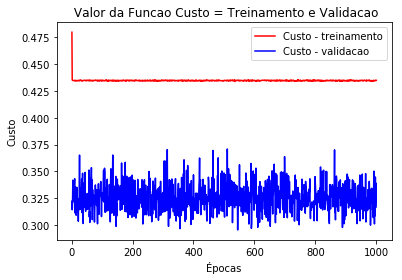

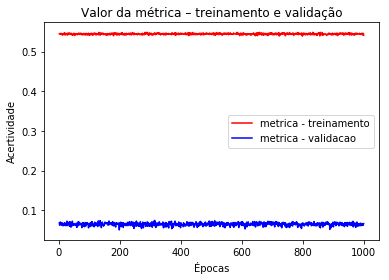

In [38]:
rna3.train(x_train_norm,y_train,x_val_norm,y_val,batch_size,epochs,loss,metric)
rna3.plot()

Confusion matrix, without normalization
[[24775  2210]
 [ 1495  1520]]


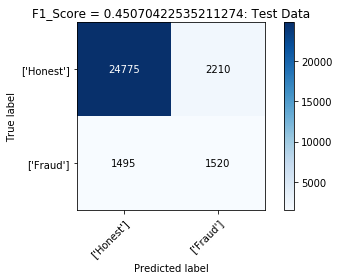

Confusion matrix, without normalization
[[24826  2160]
 [ 1509  1506]]


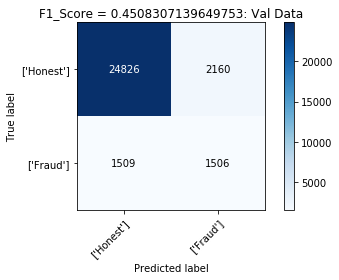

Confusion matrix, without normalization
[[116058   9873]
 [ 20640  21564]]


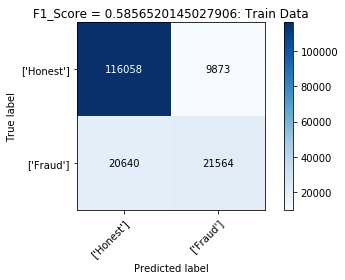

In [39]:
rna3.predict(x_data,y_data)

In [40]:
n_list4 = [50,50,50,1]
activation_list4 = ['tanh','tanh','tanh','sigmoid']
dropout_list4 = [0.1,0.1,0.1]

In [41]:
rna4 = new_rna()
rna4.build_model(data_shape,n_list4,activation_list4,dropout_list4)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                10050     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                2550      
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 51        
Total para

Train on 168135 samples, validate on 30001 samples
Epoch 1/1000
168135/168135 [==============================] - 10s 61us/step - loss: 0.4830 - f1: 0.5397 - val_loss: 0.3307 - val_f1: 0.0685
Epoch 2/1000
168135/168135 [==============================] - 10s 57us/step - loss: 0.4401 - f1: 0.5444 - val_loss: 0.3524 - val_f1: 0.0689
Epoch 3/1000
168135/168135 [==============================] - 10s 57us/step - loss: 0.4398 - f1: 0.5412 - val_loss: 0.3212 - val_f1: 0.0628
Epoch 4/1000
168135/168135 [==============================] - 9s 56us/step - loss: 0.4403 - f1: 0.5414 - val_loss: 0.3071 - val_f1: 0.0588
Epoch 5/1000
168135/168135 [==============================] - 10s 57us/step - loss: 0.4403 - f1: 0.5432 - val_loss: 0.3287 - val_f1: 0.0692
Epoch 6/1000
168135/168135 [==============================] - 9s 56us/step - loss: 0.4404 - f1: 0.5407 - val_loss: 0.3232 - val_f1: 0.0638
Epoch 7/1000
168135/168135 [==============================] - 10s 57us/step - loss: 0.4401 - f1: 0.5412 - val_l

Epoch 59/1000
168135/168135 [==============================] - 9s 56us/step - loss: 0.4397 - f1: 0.5406 - val_loss: 0.3361 - val_f1: 0.0645
Epoch 60/1000
168135/168135 [==============================] - 10s 57us/step - loss: 0.4398 - f1: 0.5426 - val_loss: 0.3166 - val_f1: 0.0600
Epoch 61/1000
168135/168135 [==============================] - 10s 57us/step - loss: 0.4403 - f1: 0.5409 - val_loss: 0.3362 - val_f1: 0.0668
Epoch 62/1000
168135/168135 [==============================] - 9s 56us/step - loss: 0.4398 - f1: 0.5452 - val_loss: 0.3059 - val_f1: 0.0587
Epoch 63/1000
168135/168135 [==============================] - 10s 57us/step - loss: 0.4404 - f1: 0.5404 - val_loss: 0.3206 - val_f1: 0.0609
Epoch 64/1000
168135/168135 [==============================] - 9s 56us/step - loss: 0.4404 - f1: 0.5436 - val_loss: 0.3202 - val_f1: 0.0627
Epoch 65/1000
168135/168135 [==============================] - 10s 57us/step - loss: 0.4401 - f1: 0.5445 - val_loss: 0.3119 - val_f1: 0.0598
Epoch 66/1000
16

168135/168135 [==============================] - 9s 56us/step - loss: 0.4400 - f1: 0.5416 - val_loss: 0.3566 - val_f1: 0.0695
Epoch 118/1000
168135/168135 [==============================] - 9s 56us/step - loss: 0.4400 - f1: 0.5416 - val_loss: 0.3252 - val_f1: 0.0664
Epoch 119/1000
168135/168135 [==============================] - 10s 57us/step - loss: 0.4404 - f1: 0.5404 - val_loss: 0.3116 - val_f1: 0.0631
Epoch 120/1000
168135/168135 [==============================] - 10s 57us/step - loss: 0.4400 - f1: 0.5385 - val_loss: 0.3533 - val_f1: 0.0713
Epoch 121/1000
168135/168135 [==============================] - 9s 55us/step - loss: 0.4400 - f1: 0.5420 - val_loss: 0.3292 - val_f1: 0.0677
Epoch 122/1000
168135/168135 [==============================] - 10s 57us/step - loss: 0.4402 - f1: 0.5412 - val_loss: 0.3244 - val_f1: 0.0657
Epoch 123/1000
168135/168135 [==============================] - 9s 55us/step - loss: 0.4402 - f1: 0.5414 - val_loss: 0.3152 - val_f1: 0.0643
Epoch 124/1000
168135/168

Epoch 175/1000
168135/168135 [==============================] - 9s 56us/step - loss: 0.4397 - f1: 0.5428 - val_loss: 0.3139 - val_f1: 0.0591
Epoch 176/1000
168135/168135 [==============================] - 9s 56us/step - loss: 0.4401 - f1: 0.5418 - val_loss: 0.3227 - val_f1: 0.0625
Epoch 177/1000
168135/168135 [==============================] - 9s 56us/step - loss: 0.4399 - f1: 0.5416 - val_loss: 0.3078 - val_f1: 0.0480
Epoch 178/1000
168135/168135 [==============================] - 10s 57us/step - loss: 0.4400 - f1: 0.5400 - val_loss: 0.3128 - val_f1: 0.0603
Epoch 179/1000
168135/168135 [==============================] - 9s 56us/step - loss: 0.4400 - f1: 0.5420 - val_loss: 0.3510 - val_f1: 0.0711
Epoch 180/1000
168135/168135 [==============================] - 10s 57us/step - loss: 0.4393 - f1: 0.5459 - val_loss: 0.3468 - val_f1: 0.0641
Epoch 181/1000
168135/168135 [==============================] - 9s 56us/step - loss: 0.4397 - f1: 0.5433 - val_loss: 0.3554 - val_f1: 0.0718
Epoch 182/1

Epoch 233/1000
168135/168135 [==============================] - 9s 56us/step - loss: 0.4404 - f1: 0.5429 - val_loss: 0.3098 - val_f1: 0.0623
Epoch 234/1000
168135/168135 [==============================] - 10s 58us/step - loss: 0.4402 - f1: 0.5440 - val_loss: 0.3239 - val_f1: 0.0648
Epoch 235/1000
168135/168135 [==============================] - 9s 56us/step - loss: 0.4400 - f1: 0.5432 - val_loss: 0.3319 - val_f1: 0.0665
Epoch 236/1000
168135/168135 [==============================] - 10s 57us/step - loss: 0.4400 - f1: 0.5405 - val_loss: 0.3295 - val_f1: 0.0664
Epoch 237/1000
168135/168135 [==============================] - 10s 57us/step - loss: 0.4394 - f1: 0.5399 - val_loss: 0.3641 - val_f1: 0.0718
Epoch 238/1000
168135/168135 [==============================] - 9s 56us/step - loss: 0.4397 - f1: 0.5441 - val_loss: 0.3128 - val_f1: 0.0578
Epoch 239/1000
168135/168135 [==============================] - 10s 57us/step - loss: 0.4403 - f1: 0.5432 - val_loss: 0.3470 - val_f1: 0.0688
Epoch 240

Epoch 291/1000
168135/168135 [==============================] - 10s 58us/step - loss: 0.4404 - f1: 0.5405 - val_loss: 0.3220 - val_f1: 0.0630
Epoch 292/1000
168135/168135 [==============================] - 9s 56us/step - loss: 0.4400 - f1: 0.5403 - val_loss: 0.3228 - val_f1: 0.0613
Epoch 293/1000
168135/168135 [==============================] - 10s 57us/step - loss: 0.4393 - f1: 0.5433 - val_loss: 0.3200 - val_f1: 0.0635
Epoch 294/1000
168135/168135 [==============================] - 9s 56us/step - loss: 0.4397 - f1: 0.5443 - val_loss: 0.3362 - val_f1: 0.0632
Epoch 295/1000
168135/168135 [==============================] - 10s 57us/step - loss: 0.4402 - f1: 0.5379 - val_loss: 0.3328 - val_f1: 0.0682
Epoch 296/1000
168135/168135 [==============================] - 10s 57us/step - loss: 0.4401 - f1: 0.5431 - val_loss: 0.3447 - val_f1: 0.0682
Epoch 297/1000
168135/168135 [==============================] - 9s 56us/step - loss: 0.4404 - f1: 0.5388 - val_loss: 0.3491 - val_f1: 0.0713
Epoch 298

Epoch 349/1000
168135/168135 [==============================] - 10s 57us/step - loss: 0.4395 - f1: 0.5406 - val_loss: 0.3322 - val_f1: 0.0687
Epoch 350/1000
168135/168135 [==============================] - 10s 57us/step - loss: 0.4405 - f1: 0.5419 - val_loss: 0.3199 - val_f1: 0.0662
Epoch 351/1000
168135/168135 [==============================] - 10s 57us/step - loss: 0.4399 - f1: 0.5455 - val_loss: 0.3389 - val_f1: 0.0674
Epoch 352/1000
168135/168135 [==============================] - 9s 56us/step - loss: 0.4396 - f1: 0.5428 - val_loss: 0.3234 - val_f1: 0.0629
Epoch 353/1000
168135/168135 [==============================] - 9s 56us/step - loss: 0.4396 - f1: 0.5431 - val_loss: 0.3356 - val_f1: 0.0664
Epoch 354/1000
168135/168135 [==============================] - 9s 56us/step - loss: 0.4403 - f1: 0.5409 - val_loss: 0.3249 - val_f1: 0.0671
Epoch 355/1000
168135/168135 [==============================] - 10s 57us/step - loss: 0.4400 - f1: 0.5429 - val_loss: 0.3059 - val_f1: 0.0580
Epoch 356

Epoch 407/1000
168135/168135 [==============================] - 10s 57us/step - loss: 0.4402 - f1: 0.5403 - val_loss: 0.3186 - val_f1: 0.0644
Epoch 408/1000
168135/168135 [==============================] - 9s 56us/step - loss: 0.4399 - f1: 0.5409 - val_loss: 0.3424 - val_f1: 0.0686
Epoch 409/1000
168135/168135 [==============================] - 10s 57us/step - loss: 0.4401 - f1: 0.5442 - val_loss: 0.3169 - val_f1: 0.0644
Epoch 410/1000
168135/168135 [==============================] - 9s 56us/step - loss: 0.4399 - f1: 0.5440 - val_loss: 0.3077 - val_f1: 0.0603
Epoch 411/1000
168135/168135 [==============================] - 10s 57us/step - loss: 0.4402 - f1: 0.5396 - val_loss: 0.3133 - val_f1: 0.0579
Epoch 412/1000
168135/168135 [==============================] - 10s 57us/step - loss: 0.4400 - f1: 0.5405 - val_loss: 0.3396 - val_f1: 0.0562
Epoch 413/1000
168135/168135 [==============================] - 9s 56us/step - loss: 0.4404 - f1: 0.5418 - val_loss: 0.3463 - val_f1: 0.0657
Epoch 414

Epoch 465/1000
168135/168135 [==============================] - 10s 57us/step - loss: 0.4400 - f1: 0.5454 - val_loss: 0.3333 - val_f1: 0.0670
Epoch 466/1000
168135/168135 [==============================] - 9s 56us/step - loss: 0.4401 - f1: 0.5417 - val_loss: 0.3246 - val_f1: 0.0664
Epoch 467/1000
168135/168135 [==============================] - 10s 57us/step - loss: 0.4402 - f1: 0.5428 - val_loss: 0.3163 - val_f1: 0.0648
Epoch 468/1000
168135/168135 [==============================] - 10s 57us/step - loss: 0.4403 - f1: 0.5409 - val_loss: 0.3406 - val_f1: 0.0639
Epoch 469/1000
168135/168135 [==============================] - 9s 56us/step - loss: 0.4401 - f1: 0.5382 - val_loss: 0.3317 - val_f1: 0.0683
Epoch 470/1000
168135/168135 [==============================] - 10s 57us/step - loss: 0.4398 - f1: 0.5418 - val_loss: 0.3508 - val_f1: 0.0709
Epoch 471/1000
168135/168135 [==============================] - 9s 56us/step - loss: 0.4399 - f1: 0.5424 - val_loss: 0.3897 - val_f1: 0.0766
Epoch 472

Epoch 523/1000
168135/168135 [==============================] - 9s 56us/step - loss: 0.4403 - f1: 0.5444 - val_loss: 0.3374 - val_f1: 0.0659
Epoch 524/1000
168135/168135 [==============================] - 10s 57us/step - loss: 0.4393 - f1: 0.5451 - val_loss: 0.3025 - val_f1: 0.0583
Epoch 525/1000
168135/168135 [==============================] - 9s 56us/step - loss: 0.4398 - f1: 0.5435 - val_loss: 0.3222 - val_f1: 0.0649
Epoch 526/1000
168135/168135 [==============================] - 9s 56us/step - loss: 0.4399 - f1: 0.5422 - val_loss: 0.3336 - val_f1: 0.0621
Epoch 527/1000
168135/168135 [==============================] - 10s 58us/step - loss: 0.4398 - f1: 0.5410 - val_loss: 0.3232 - val_f1: 0.0640
Epoch 528/1000
168135/168135 [==============================] - 9s 56us/step - loss: 0.4405 - f1: 0.5414 - val_loss: 0.3596 - val_f1: 0.0729
Epoch 529/1000
168135/168135 [==============================] - 10s 57us/step - loss: 0.4394 - f1: 0.5434 - val_loss: 0.3432 - val_f1: 0.0672
Epoch 530/

Epoch 581/1000
168135/168135 [==============================] - 10s 57us/step - loss: 0.4403 - f1: 0.5400 - val_loss: 0.3309 - val_f1: 0.0620
Epoch 582/1000
168135/168135 [==============================] - 10s 57us/step - loss: 0.4396 - f1: 0.5412 - val_loss: 0.3834 - val_f1: 0.0742
Epoch 583/1000
168135/168135 [==============================] - 9s 56us/step - loss: 0.4396 - f1: 0.5427 - val_loss: 0.3314 - val_f1: 0.0643
Epoch 584/1000
168135/168135 [==============================] - 10s 57us/step - loss: 0.4399 - f1: 0.5449 - val_loss: 0.3400 - val_f1: 0.0617
Epoch 585/1000
168135/168135 [==============================] - 10s 57us/step - loss: 0.4404 - f1: 0.5409 - val_loss: 0.3453 - val_f1: 0.0673
Epoch 586/1000
168135/168135 [==============================] - 10s 57us/step - loss: 0.4398 - f1: 0.5435 - val_loss: 0.3271 - val_f1: 0.0656
Epoch 587/1000
168135/168135 [==============================] - 10s 57us/step - loss: 0.4403 - f1: 0.5407 - val_loss: 0.3277 - val_f1: 0.0574
Epoch 5

Epoch 639/1000
168135/168135 [==============================] - 9s 56us/step - loss: 0.4391 - f1: 0.5431 - val_loss: 0.3400 - val_f1: 0.0696
Epoch 640/1000
168135/168135 [==============================] - 10s 57us/step - loss: 0.4397 - f1: 0.5421 - val_loss: 0.3261 - val_f1: 0.0649
Epoch 641/1000
168135/168135 [==============================] - 10s 58us/step - loss: 0.4403 - f1: 0.5435 - val_loss: 0.3381 - val_f1: 0.0695
Epoch 642/1000
168135/168135 [==============================] - 9s 56us/step - loss: 0.4400 - f1: 0.5418 - val_loss: 0.3063 - val_f1: 0.0623
Epoch 643/1000
168135/168135 [==============================] - 10s 57us/step - loss: 0.4404 - f1: 0.5395 - val_loss: 0.3255 - val_f1: 0.0635
Epoch 644/1000
168135/168135 [==============================] - 9s 56us/step - loss: 0.4399 - f1: 0.5406 - val_loss: 0.3170 - val_f1: 0.0574
Epoch 645/1000
168135/168135 [==============================] - 10s 57us/step - loss: 0.4399 - f1: 0.5413 - val_loss: 0.3017 - val_f1: 0.0611
Epoch 646

Epoch 697/1000
168135/168135 [==============================] - 10s 57us/step - loss: 0.4397 - f1: 0.5436 - val_loss: 0.3304 - val_f1: 0.0638
Epoch 698/1000
168135/168135 [==============================] - 9s 55us/step - loss: 0.4404 - f1: 0.5437 - val_loss: 0.3457 - val_f1: 0.0696
Epoch 699/1000
168135/168135 [==============================] - 10s 57us/step - loss: 0.4403 - f1: 0.5389 - val_loss: 0.3579 - val_f1: 0.0719
Epoch 700/1000
168135/168135 [==============================] - 9s 55us/step - loss: 0.4405 - f1: 0.5436 - val_loss: 0.3282 - val_f1: 0.0594
Epoch 701/1000
168135/168135 [==============================] - 10s 58us/step - loss: 0.4401 - f1: 0.5423 - val_loss: 0.3367 - val_f1: 0.0652
Epoch 702/1000
168135/168135 [==============================] - 10s 57us/step - loss: 0.4398 - f1: 0.5416 - val_loss: 0.2964 - val_f1: 0.0580
Epoch 703/1000
168135/168135 [==============================] - 9s 56us/step - loss: 0.4405 - f1: 0.5392 - val_loss: 0.3149 - val_f1: 0.0567
Epoch 704

Epoch 755/1000
168135/168135 [==============================] - 9s 56us/step - loss: 0.4402 - f1: 0.5411 - val_loss: 0.3423 - val_f1: 0.0702
Epoch 756/1000
168135/168135 [==============================] - 10s 59us/step - loss: 0.4396 - f1: 0.5435 - val_loss: 0.3272 - val_f1: 0.0629
Epoch 757/1000
168135/168135 [==============================] - 9s 56us/step - loss: 0.4403 - f1: 0.5392 - val_loss: 0.3192 - val_f1: 0.0650
Epoch 758/1000
168135/168135 [==============================] - 10s 57us/step - loss: 0.4398 - f1: 0.5420 - val_loss: 0.3261 - val_f1: 0.0604
Epoch 759/1000
168135/168135 [==============================] - 10s 57us/step - loss: 0.4398 - f1: 0.5392 - val_loss: 0.3152 - val_f1: 0.0639
Epoch 760/1000
168135/168135 [==============================] - 9s 56us/step - loss: 0.4399 - f1: 0.5418 - val_loss: 0.3148 - val_f1: 0.0653
Epoch 761/1000
168135/168135 [==============================] - 10s 57us/step - loss: 0.4398 - f1: 0.5409 - val_loss: 0.3150 - val_f1: 0.0581
Epoch 762

Epoch 813/1000
168135/168135 [==============================] - 9s 56us/step - loss: 0.4394 - f1: 0.5439 - val_loss: 0.3364 - val_f1: 0.0705
Epoch 814/1000
168135/168135 [==============================] - 10s 58us/step - loss: 0.4398 - f1: 0.5405 - val_loss: 0.3376 - val_f1: 0.0704
Epoch 815/1000
168135/168135 [==============================] - 10s 57us/step - loss: 0.4395 - f1: 0.5449 - val_loss: 0.3103 - val_f1: 0.0614
Epoch 816/1000
168135/168135 [==============================] - 9s 56us/step - loss: 0.4396 - f1: 0.5441 - val_loss: 0.3205 - val_f1: 0.0592
Epoch 817/1000
168135/168135 [==============================] - 10s 57us/step - loss: 0.4401 - f1: 0.5397 - val_loss: 0.3588 - val_f1: 0.0701
Epoch 818/1000
168135/168135 [==============================] - 9s 56us/step - loss: 0.4401 - f1: 0.5406 - val_loss: 0.3285 - val_f1: 0.0637
Epoch 819/1000
168135/168135 [==============================] - 10s 57us/step - loss: 0.4396 - f1: 0.5424 - val_loss: 0.3129 - val_f1: 0.0640
Epoch 820

Epoch 871/1000
168135/168135 [==============================] - 10s 58us/step - loss: 0.4401 - f1: 0.5434 - val_loss: 0.3152 - val_f1: 0.0671
Epoch 872/1000
168135/168135 [==============================] - 9s 56us/step - loss: 0.4400 - f1: 0.5410 - val_loss: 0.3000 - val_f1: 0.0574
Epoch 873/1000
168135/168135 [==============================] - 9s 56us/step - loss: 0.4398 - f1: 0.5440 - val_loss: 0.3074 - val_f1: 0.0573
Epoch 874/1000
168135/168135 [==============================] - 9s 56us/step - loss: 0.4400 - f1: 0.5392 - val_loss: 0.3324 - val_f1: 0.0685
Epoch 875/1000
168135/168135 [==============================] - 10s 57us/step - loss: 0.4399 - f1: 0.5436 - val_loss: 0.3348 - val_f1: 0.0643
Epoch 876/1000
168135/168135 [==============================] - 9s 56us/step - loss: 0.4403 - f1: 0.5430 - val_loss: 0.2880 - val_f1: 0.0477
Epoch 877/1000
168135/168135 [==============================] - 10s 57us/step - loss: 0.4400 - f1: 0.5423 - val_loss: 0.3359 - val_f1: 0.0678
Epoch 878/

Epoch 929/1000
168135/168135 [==============================] - 10s 57us/step - loss: 0.4404 - f1: 0.5451 - val_loss: 0.3754 - val_f1: 0.0741
Epoch 930/1000
168135/168135 [==============================] - 9s 56us/step - loss: 0.4403 - f1: 0.5421 - val_loss: 0.3599 - val_f1: 0.0728
Epoch 931/1000
168135/168135 [==============================] - 10s 57us/step - loss: 0.4399 - f1: 0.5391 - val_loss: 0.3204 - val_f1: 0.0593
Epoch 932/1000
168135/168135 [==============================] - 9s 56us/step - loss: 0.4398 - f1: 0.5432 - val_loss: 0.3045 - val_f1: 0.0556
Epoch 933/1000
168135/168135 [==============================] - 9s 56us/step - loss: 0.4402 - f1: 0.5414 - val_loss: 0.3752 - val_f1: 0.0730
Epoch 934/1000
168135/168135 [==============================] - 10s 57us/step - loss: 0.4402 - f1: 0.5407 - val_loss: 0.3163 - val_f1: 0.0634
Epoch 935/1000
168135/168135 [==============================] - 9s 56us/step - loss: 0.4400 - f1: 0.5448 - val_loss: 0.3228 - val_f1: 0.0655
Epoch 936/

Epoch 987/1000
168135/168135 [==============================] - 10s 57us/step - loss: 0.4400 - f1: 0.5405 - val_loss: 0.3276 - val_f1: 0.0676
Epoch 988/1000
168135/168135 [==============================] - 9s 55us/step - loss: 0.4398 - f1: 0.5438 - val_loss: 0.3354 - val_f1: 0.0663
Epoch 989/1000
168135/168135 [==============================] - 10s 57us/step - loss: 0.4399 - f1: 0.5421 - val_loss: 0.3259 - val_f1: 0.0639
Epoch 990/1000
168135/168135 [==============================] - 9s 56us/step - loss: 0.4402 - f1: 0.5415 - val_loss: 0.3655 - val_f1: 0.0708
Epoch 991/1000
168135/168135 [==============================] - 10s 57us/step - loss: 0.4392 - f1: 0.5432 - val_loss: 0.3194 - val_f1: 0.0577
Epoch 992/1000
168135/168135 [==============================] - 10s 57us/step - loss: 0.4399 - f1: 0.5402 - val_loss: 0.3475 - val_f1: 0.0708
Epoch 993/1000
168135/168135 [==============================] - 9s 56us/step - loss: 0.4397 - f1: 0.5410 - val_loss: 0.3175 - val_f1: 0.0573
Epoch 994

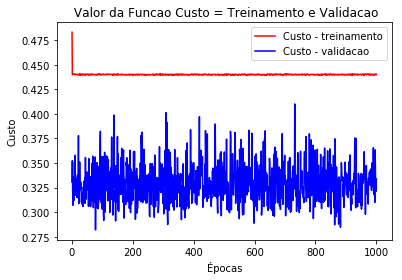

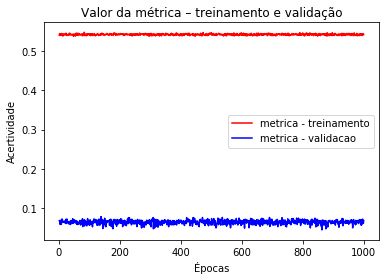

In [42]:
rna4.train(x_train_norm,y_train,x_val_norm,y_val,batch_size,epochs,loss,metric)
rna4.plot()

Confusion matrix, without normalization
[[24803  2182]
 [ 1482  1533]]


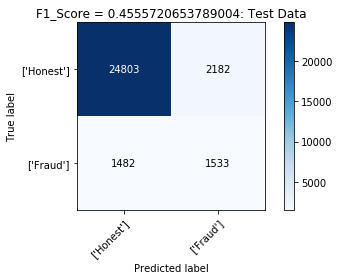

Confusion matrix, without normalization
[[24837  2149]
 [ 1430  1585]]


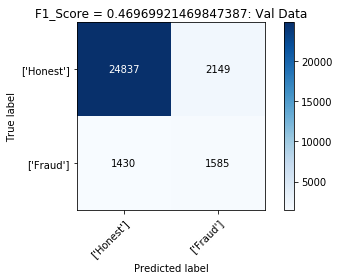

Confusion matrix, without normalization
[[116041   9890]
 [ 20541  21663]]


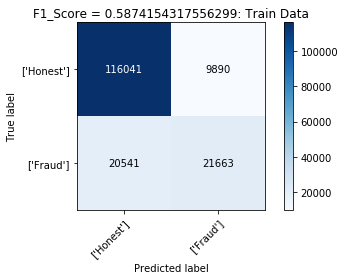

In [43]:
rna4.predict(x_data,y_data)

In [44]:
n_list5 = [100,100,100,1]
activation_list5 = ['tanh','tanh','tanh','sigmoid']
dropout_list5 = [0.1,0.1,0.1]

In [45]:
rna5 = new_rna()
rna5.build_model(data_shape,n_list5,activation_list5,dropout_list5)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total para

Train on 168135 samples, validate on 30001 samples
Epoch 1/1000
168135/168135 [==============================] - 13s 76us/step - loss: 0.5229 - f1: 0.5393 - val_loss: 0.3274 - val_f1: 0.0678
Epoch 2/1000
168135/168135 [==============================] - 12s 72us/step - loss: 0.4397 - f1: 0.5445 - val_loss: 0.3285 - val_f1: 0.0663
Epoch 3/1000
168135/168135 [==============================] - 12s 71us/step - loss: 0.4393 - f1: 0.5423 - val_loss: 0.3077 - val_f1: 0.0615
Epoch 4/1000
168135/168135 [==============================] - 12s 72us/step - loss: 0.4398 - f1: 0.5404 - val_loss: 0.3379 - val_f1: 0.0702
Epoch 5/1000
168135/168135 [==============================] - 12s 71us/step - loss: 0.4398 - f1: 0.5397 - val_loss: 0.3056 - val_f1: 0.0614
Epoch 6/1000
168135/168135 [==============================] - 12s 71us/step - loss: 0.4404 - f1: 0.5392 - val_loss: 0.3131 - val_f1: 0.0634
Epoch 7/1000
168135/168135 [==============================] - 12s 72us/step - loss: 0.4397 - f1: 0.5404 - val

Epoch 59/1000
168135/168135 [==============================] - 12s 71us/step - loss: 0.4390 - f1: 0.5439 - val_loss: 0.3877 - val_f1: 0.0749
Epoch 60/1000
168135/168135 [==============================] - 12s 72us/step - loss: 0.4395 - f1: 0.5402 - val_loss: 0.3240 - val_f1: 0.0632
Epoch 61/1000
168135/168135 [==============================] - 12s 70us/step - loss: 0.4392 - f1: 0.5429 - val_loss: 0.3129 - val_f1: 0.0652
Epoch 62/1000
168135/168135 [==============================] - 12s 72us/step - loss: 0.4394 - f1: 0.5406 - val_loss: 0.2923 - val_f1: 0.0533
Epoch 63/1000
168135/168135 [==============================] - 12s 71us/step - loss: 0.4392 - f1: 0.5415 - val_loss: 0.3179 - val_f1: 0.0628
Epoch 64/1000
168135/168135 [==============================] - 12s 72us/step - loss: 0.4395 - f1: 0.5388 - val_loss: 0.3324 - val_f1: 0.0702
Epoch 65/1000
168135/168135 [==============================] - 12s 70us/step - loss: 0.4400 - f1: 0.5425 - val_loss: 0.3269 - val_f1: 0.0610
Epoch 66/1000

Epoch 117/1000
168135/168135 [==============================] - 12s 70us/step - loss: 0.4398 - f1: 0.5429 - val_loss: 0.3036 - val_f1: 0.0584
Epoch 118/1000
168135/168135 [==============================] - 12s 71us/step - loss: 0.4391 - f1: 0.5417 - val_loss: 0.3076 - val_f1: 0.0613
Epoch 119/1000
168135/168135 [==============================] - 12s 71us/step - loss: 0.4394 - f1: 0.5416 - val_loss: 0.3443 - val_f1: 0.0716
Epoch 120/1000
168135/168135 [==============================] - 12s 72us/step - loss: 0.4395 - f1: 0.5419 - val_loss: 0.3050 - val_f1: 0.0610
Epoch 121/1000
168135/168135 [==============================] - 12s 70us/step - loss: 0.4397 - f1: 0.5421 - val_loss: 0.3133 - val_f1: 0.0492
Epoch 122/1000
168135/168135 [==============================] - 12s 72us/step - loss: 0.4396 - f1: 0.5420 - val_loss: 0.3450 - val_f1: 0.0654
Epoch 123/1000
168135/168135 [==============================] - 12s 71us/step - loss: 0.4395 - f1: 0.5436 - val_loss: 0.3389 - val_f1: 0.0678
Epoch 

168135/168135 [==============================] - 12s 71us/step - loss: 0.4394 - f1: 0.5405 - val_loss: 0.3340 - val_f1: 0.0671
Epoch 175/1000
168135/168135 [==============================] - 12s 70us/step - loss: 0.4398 - f1: 0.5413 - val_loss: 0.3269 - val_f1: 0.0651
Epoch 176/1000
168135/168135 [==============================] - 12s 71us/step - loss: 0.4396 - f1: 0.5410 - val_loss: 0.3321 - val_f1: 0.0657
Epoch 177/1000
168135/168135 [==============================] - 12s 71us/step - loss: 0.4397 - f1: 0.5420 - val_loss: 0.3566 - val_f1: 0.0713
Epoch 178/1000
168135/168135 [==============================] - 12s 70us/step - loss: 0.4392 - f1: 0.5403 - val_loss: 0.3344 - val_f1: 0.0696
Epoch 179/1000
168135/168135 [==============================] - 12s 72us/step - loss: 0.4394 - f1: 0.5394 - val_loss: 0.3704 - val_f1: 0.0749
Epoch 180/1000
168135/168135 [==============================] - 12s 72us/step - loss: 0.4395 - f1: 0.5423 - val_loss: 0.3377 - val_f1: 0.0696
Epoch 181/1000
168135

Epoch 232/1000
168135/168135 [==============================] - 12s 71us/step - loss: 0.4395 - f1: 0.5379 - val_loss: 0.3171 - val_f1: 0.0632
Epoch 233/1000
168135/168135 [==============================] - 12s 71us/step - loss: 0.4393 - f1: 0.5399 - val_loss: 0.3093 - val_f1: 0.0619
Epoch 234/1000
168135/168135 [==============================] - 12s 71us/step - loss: 0.4398 - f1: 0.5407 - val_loss: 0.3066 - val_f1: 0.0609
Epoch 235/1000
168135/168135 [==============================] - 12s 71us/step - loss: 0.4392 - f1: 0.5394 - val_loss: 0.3465 - val_f1: 0.0721
Epoch 236/1000
168135/168135 [==============================] - 12s 72us/step - loss: 0.4395 - f1: 0.5407 - val_loss: 0.3422 - val_f1: 0.0679
Epoch 237/1000
168135/168135 [==============================] - 12s 70us/step - loss: 0.4395 - f1: 0.5408 - val_loss: 0.3347 - val_f1: 0.0702
Epoch 238/1000
168135/168135 [==============================] - 12s 72us/step - loss: 0.4398 - f1: 0.5384 - val_loss: 0.3420 - val_f1: 0.0722
Epoch 

168135/168135 [==============================] - 12s 72us/step - loss: 0.4395 - f1: 0.5427 - val_loss: 0.3489 - val_f1: 0.0667
Epoch 290/1000
168135/168135 [==============================] - 12s 71us/step - loss: 0.4393 - f1: 0.5416 - val_loss: 0.3322 - val_f1: 0.0644
Epoch 291/1000
168135/168135 [==============================] - 12s 72us/step - loss: 0.4392 - f1: 0.5401 - val_loss: 0.3007 - val_f1: 0.0494
Epoch 292/1000
168135/168135 [==============================] - 12s 70us/step - loss: 0.4394 - f1: 0.5439 - val_loss: 0.3599 - val_f1: 0.0678
Epoch 293/1000
168135/168135 [==============================] - 12s 71us/step - loss: 0.4394 - f1: 0.5399 - val_loss: 0.3213 - val_f1: 0.0652
Epoch 294/1000
168135/168135 [==============================] - 12s 71us/step - loss: 0.4393 - f1: 0.5386 - val_loss: 0.3219 - val_f1: 0.0677
Epoch 295/1000
168135/168135 [==============================] - 12s 72us/step - loss: 0.4397 - f1: 0.5391 - val_loss: 0.3319 - val_f1: 0.0684
Epoch 296/1000
168135

Epoch 347/1000
168135/168135 [==============================] - 12s 72us/step - loss: 0.4396 - f1: 0.5403 - val_loss: 0.3507 - val_f1: 0.0693
Epoch 348/1000
168135/168135 [==============================] - 12s 72us/step - loss: 0.4389 - f1: 0.5413 - val_loss: 0.3537 - val_f1: 0.0711
Epoch 349/1000
168135/168135 [==============================] - 12s 70us/step - loss: 0.4394 - f1: 0.5421 - val_loss: 0.3614 - val_f1: 0.0675
Epoch 350/1000
168135/168135 [==============================] - 12s 72us/step - loss: 0.4395 - f1: 0.5412 - val_loss: 0.3295 - val_f1: 0.0680
Epoch 351/1000
168135/168135 [==============================] - 12s 71us/step - loss: 0.4396 - f1: 0.5423 - val_loss: 0.3185 - val_f1: 0.0637
Epoch 352/1000
168135/168135 [==============================] - 12s 72us/step - loss: 0.4393 - f1: 0.5425 - val_loss: 0.3300 - val_f1: 0.0648
Epoch 353/1000
168135/168135 [==============================] - 12s 70us/step - loss: 0.4395 - f1: 0.5411 - val_loss: 0.3205 - val_f1: 0.0621
Epoch 

168135/168135 [==============================] - 12s 70us/step - loss: 0.4395 - f1: 0.5416 - val_loss: 0.3631 - val_f1: 0.0709
Epoch 405/1000
168135/168135 [==============================] - 12s 71us/step - loss: 0.4395 - f1: 0.5427 - val_loss: 0.3249 - val_f1: 0.0635
Epoch 406/1000
168135/168135 [==============================] - 12s 71us/step - loss: 0.4394 - f1: 0.5414 - val_loss: 0.2986 - val_f1: 0.0580
Epoch 407/1000
168135/168135 [==============================] - 12s 72us/step - loss: 0.4397 - f1: 0.5406 - val_loss: 0.3127 - val_f1: 0.0635
Epoch 408/1000
168135/168135 [==============================] - 12s 70us/step - loss: 0.4391 - f1: 0.5432 - val_loss: 0.3361 - val_f1: 0.0680
Epoch 409/1000
168135/168135 [==============================] - 12s 72us/step - loss: 0.4395 - f1: 0.5381 - val_loss: 0.3360 - val_f1: 0.0671
Epoch 410/1000
168135/168135 [==============================] - 12s 71us/step - loss: 0.4395 - f1: 0.5428 - val_loss: 0.3053 - val_f1: 0.0577
Epoch 411/1000
168135

Epoch 462/1000
168135/168135 [==============================] - 12s 71us/step - loss: 0.4396 - f1: 0.5403 - val_loss: 0.3062 - val_f1: 0.0638
Epoch 463/1000
168135/168135 [==============================] - 12s 72us/step - loss: 0.4394 - f1: 0.5433 - val_loss: 0.3650 - val_f1: 0.0720
Epoch 464/1000
168135/168135 [==============================] - 12s 71us/step - loss: 0.4396 - f1: 0.5424 - val_loss: 0.3184 - val_f1: 0.0645
Epoch 465/1000
168135/168135 [==============================] - 12s 72us/step - loss: 0.4395 - f1: 0.5385 - val_loss: 0.3219 - val_f1: 0.0658
Epoch 466/1000
168135/168135 [==============================] - 12s 72us/step - loss: 0.4394 - f1: 0.5405 - val_loss: 0.3424 - val_f1: 0.0701
Epoch 467/1000
168135/168135 [==============================] - 12s 70us/step - loss: 0.4393 - f1: 0.5420 - val_loss: 0.2954 - val_f1: 0.0520
Epoch 468/1000
168135/168135 [==============================] - 12s 72us/step - loss: 0.4394 - f1: 0.5419 - val_loss: 0.3174 - val_f1: 0.0609
Epoch 

168135/168135 [==============================] - 12s 71us/step - loss: 0.4401 - f1: 0.5388 - val_loss: 0.3357 - val_f1: 0.0667
Epoch 520/1000
168135/168135 [==============================] - 12s 71us/step - loss: 0.4390 - f1: 0.5422 - val_loss: 0.3143 - val_f1: 0.0625
Epoch 521/1000
168135/168135 [==============================] - 12s 70us/step - loss: 0.4394 - f1: 0.5400 - val_loss: 0.3519 - val_f1: 0.0672
Epoch 522/1000
168135/168135 [==============================] - 12s 71us/step - loss: 0.4400 - f1: 0.5389 - val_loss: 0.3131 - val_f1: 0.0585
Epoch 523/1000
168135/168135 [==============================] - 12s 72us/step - loss: 0.4395 - f1: 0.5409 - val_loss: 0.3496 - val_f1: 0.0735
Epoch 524/1000
168135/168135 [==============================] - 12s 71us/step - loss: 0.4394 - f1: 0.5398 - val_loss: 0.3317 - val_f1: 0.0690
Epoch 525/1000
168135/168135 [==============================] - 12s 70us/step - loss: 0.4393 - f1: 0.5420 - val_loss: 0.3260 - val_f1: 0.0658
Epoch 526/1000
168135

Epoch 577/1000
168135/168135 [==============================] - 12s 72us/step - loss: 0.4394 - f1: 0.5412 - val_loss: 0.3513 - val_f1: 0.0664
Epoch 578/1000
168135/168135 [==============================] - 12s 72us/step - loss: 0.4389 - f1: 0.5432 - val_loss: 0.3518 - val_f1: 0.0638
Epoch 579/1000
168135/168135 [==============================] - 12s 72us/step - loss: 0.4399 - f1: 0.5432 - val_loss: 0.3352 - val_f1: 0.0709
Epoch 580/1000
168135/168135 [==============================] - 12s 70us/step - loss: 0.4398 - f1: 0.5408 - val_loss: 0.3296 - val_f1: 0.0650
Epoch 581/1000
168135/168135 [==============================] - 12s 71us/step - loss: 0.4397 - f1: 0.5401 - val_loss: 0.3701 - val_f1: 0.0741
Epoch 582/1000
168135/168135 [==============================] - 12s 71us/step - loss: 0.4393 - f1: 0.5413 - val_loss: 0.3036 - val_f1: 0.0598
Epoch 583/1000
168135/168135 [==============================] - 12s 71us/step - loss: 0.4395 - f1: 0.5413 - val_loss: 0.3180 - val_f1: 0.0605
Epoch 

168135/168135 [==============================] - 12s 72us/step - loss: 0.4389 - f1: 0.5425 - val_loss: 0.3352 - val_f1: 0.0676
Epoch 635/1000
168135/168135 [==============================] - 12s 72us/step - loss: 0.4398 - f1: 0.5419 - val_loss: 0.3623 - val_f1: 0.0726
Epoch 636/1000
168135/168135 [==============================] - 12s 70us/step - loss: 0.4392 - f1: 0.5400 - val_loss: 0.3112 - val_f1: 0.0626
Epoch 637/1000
168135/168135 [==============================] - 12s 71us/step - loss: 0.4405 - f1: 0.5378 - val_loss: 0.3383 - val_f1: 0.0663
Epoch 638/1000
168135/168135 [==============================] - 12s 72us/step - loss: 0.4398 - f1: 0.5399 - val_loss: 0.3165 - val_f1: 0.0641
Epoch 639/1000
168135/168135 [==============================] - 12s 72us/step - loss: 0.4393 - f1: 0.5400 - val_loss: 0.3453 - val_f1: 0.0705
Epoch 640/1000
168135/168135 [==============================] - 12s 70us/step - loss: 0.4394 - f1: 0.5429 - val_loss: 0.3449 - val_f1: 0.0691
Epoch 641/1000
168135

Epoch 692/1000
168135/168135 [==============================] - 12s 71us/step - loss: 0.4396 - f1: 0.5407 - val_loss: 0.3382 - val_f1: 0.0663
Epoch 693/1000
168135/168135 [==============================] - 12s 71us/step - loss: 0.4397 - f1: 0.5410 - val_loss: 0.3382 - val_f1: 0.0684
Epoch 694/1000
168135/168135 [==============================] - 12s 70us/step - loss: 0.4394 - f1: 0.5407 - val_loss: 0.3087 - val_f1: 0.0597
Epoch 695/1000
168135/168135 [==============================] - 12s 71us/step - loss: 0.4392 - f1: 0.5390 - val_loss: 0.3056 - val_f1: 0.0592
Epoch 696/1000
168135/168135 [==============================] - 12s 72us/step - loss: 0.4401 - f1: 0.5413 - val_loss: 0.3243 - val_f1: 0.0645
Epoch 697/1000
168135/168135 [==============================] - 12s 70us/step - loss: 0.4391 - f1: 0.5412 - val_loss: 0.3336 - val_f1: 0.0575
Epoch 698/1000
168135/168135 [==============================] - 12s 70us/step - loss: 0.4394 - f1: 0.5436 - val_loss: 0.3368 - val_f1: 0.0653
Epoch 

168135/168135 [==============================] - 12s 70us/step - loss: 0.4399 - f1: 0.5384 - val_loss: 0.3092 - val_f1: 0.0589
Epoch 750/1000
168135/168135 [==============================] - 12s 70us/step - loss: 0.4394 - f1: 0.5421 - val_loss: 0.3365 - val_f1: 0.0683
Epoch 751/1000
168135/168135 [==============================] - 12s 71us/step - loss: 0.4391 - f1: 0.5434 - val_loss: 0.3340 - val_f1: 0.0678
Epoch 752/1000
168135/168135 [==============================] - 12s 70us/step - loss: 0.4389 - f1: 0.5414 - val_loss: 0.3570 - val_f1: 0.0730
Epoch 753/1000
168135/168135 [==============================] - 12s 70us/step - loss: 0.4390 - f1: 0.5405 - val_loss: 0.3396 - val_f1: 0.0696
Epoch 754/1000
168135/168135 [==============================] - 12s 70us/step - loss: 0.4395 - f1: 0.5389 - val_loss: 0.3258 - val_f1: 0.0671
Epoch 755/1000
168135/168135 [==============================] - 12s 71us/step - loss: 0.4388 - f1: 0.5415 - val_loss: 0.3172 - val_f1: 0.0649
Epoch 756/1000
168135

Epoch 807/1000
168135/168135 [==============================] - 12s 71us/step - loss: 0.4395 - f1: 0.5399 - val_loss: 0.3109 - val_f1: 0.0631
Epoch 808/1000
168135/168135 [==============================] - 12s 70us/step - loss: 0.4391 - f1: 0.5426 - val_loss: 0.3117 - val_f1: 0.0618
Epoch 809/1000
168135/168135 [==============================] - 12s 70us/step - loss: 0.4394 - f1: 0.5422 - val_loss: 0.2987 - val_f1: 0.0525
Epoch 810/1000
168135/168135 [==============================] - 12s 70us/step - loss: 0.4390 - f1: 0.5414 - val_loss: 0.3274 - val_f1: 0.0670
Epoch 811/1000
168135/168135 [==============================] - 12s 71us/step - loss: 0.4396 - f1: 0.5424 - val_loss: 0.3521 - val_f1: 0.0713
Epoch 812/1000
168135/168135 [==============================] - 12s 70us/step - loss: 0.4391 - f1: 0.5419 - val_loss: 0.3317 - val_f1: 0.0674
Epoch 813/1000
168135/168135 [==============================] - 12s 70us/step - loss: 0.4389 - f1: 0.5407 - val_loss: 0.3193 - val_f1: 0.0641
Epoch 

168135/168135 [==============================] - 12s 71us/step - loss: 0.4396 - f1: 0.5389 - val_loss: 0.3093 - val_f1: 0.0508
Epoch 865/1000
168135/168135 [==============================] - 12s 72us/step - loss: 0.4393 - f1: 0.5404 - val_loss: 0.3040 - val_f1: 0.0574
Epoch 866/1000
168135/168135 [==============================] - 12s 71us/step - loss: 0.4396 - f1: 0.5431 - val_loss: 0.3357 - val_f1: 0.0642
Epoch 867/1000
168135/168135 [==============================] - 12s 71us/step - loss: 0.4396 - f1: 0.5385 - val_loss: 0.3164 - val_f1: 0.0606
Epoch 868/1000
168135/168135 [==============================] - 12s 72us/step - loss: 0.4396 - f1: 0.5422 - val_loss: 0.3353 - val_f1: 0.0642
Epoch 869/1000
168135/168135 [==============================] - 12s 71us/step - loss: 0.4394 - f1: 0.5415 - val_loss: 0.4043 - val_f1: 0.0742
Epoch 870/1000
168135/168135 [==============================] - 12s 71us/step - loss: 0.4393 - f1: 0.5419 - val_loss: 0.3224 - val_f1: 0.0662
Epoch 871/1000
168135

Epoch 922/1000
168135/168135 [==============================] - 12s 70us/step - loss: 0.4394 - f1: 0.5431 - val_loss: 0.3113 - val_f1: 0.0578
Epoch 923/1000
168135/168135 [==============================] - 12s 71us/step - loss: 0.4393 - f1: 0.5408 - val_loss: 0.3683 - val_f1: 0.0753
Epoch 924/1000
168135/168135 [==============================] - 12s 72us/step - loss: 0.4396 - f1: 0.5394 - val_loss: 0.3592 - val_f1: 0.0682
Epoch 925/1000
168135/168135 [==============================] - 12s 71us/step - loss: 0.4391 - f1: 0.5410 - val_loss: 0.3240 - val_f1: 0.0592
Epoch 926/1000
168135/168135 [==============================] - 12s 71us/step - loss: 0.4394 - f1: 0.5381 - val_loss: 0.3785 - val_f1: 0.0752
Epoch 927/1000
168135/168135 [==============================] - 12s 71us/step - loss: 0.4391 - f1: 0.5426 - val_loss: 0.3530 - val_f1: 0.0714
Epoch 928/1000
168135/168135 [==============================] - 12s 71us/step - loss: 0.4395 - f1: 0.5382 - val_loss: 0.3237 - val_f1: 0.0665
Epoch 

168135/168135 [==============================] - 13s 77us/step - loss: 0.4393 - f1: 0.5423 - val_loss: 0.3612 - val_f1: 0.0708
Epoch 980/1000
168135/168135 [==============================] - 13s 75us/step - loss: 0.4396 - f1: 0.5443 - val_loss: 0.3414 - val_f1: 0.0716
Epoch 981/1000
168135/168135 [==============================] - 13s 76us/step - loss: 0.4396 - f1: 0.5426 - val_loss: 0.3273 - val_f1: 0.0644
Epoch 982/1000
168135/168135 [==============================] - 13s 77us/step - loss: 0.4399 - f1: 0.5396 - val_loss: 0.3630 - val_f1: 0.0715
Epoch 983/1000
168135/168135 [==============================] - 13s 76us/step - loss: 0.4397 - f1: 0.5415 - val_loss: 0.3290 - val_f1: 0.0686
Epoch 984/1000
168135/168135 [==============================] - 13s 78us/step - loss: 0.4389 - f1: 0.5422 - val_loss: 0.3519 - val_f1: 0.0707
Epoch 985/1000
168135/168135 [==============================] - 14s 83us/step - loss: 0.4396 - f1: 0.5402 - val_loss: 0.3055 - val_f1: 0.0589
Epoch 986/1000
168135

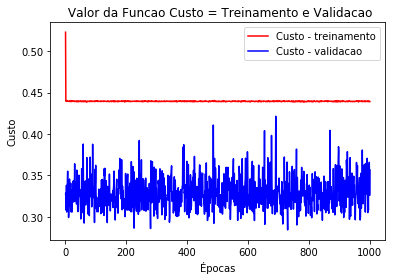

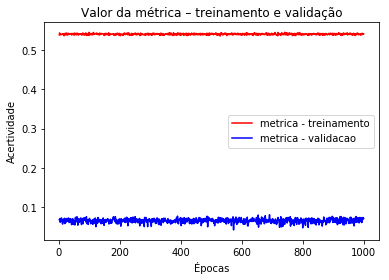

In [46]:
rna5.train(x_train_norm,y_train,x_val_norm,y_val,batch_size,epochs,loss,metric)
rna5.plot()

Confusion matrix, without normalization
[[24558  2427]
 [ 1406  1609]]


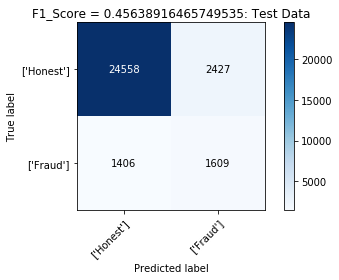

Confusion matrix, without normalization
[[24613  2373]
 [ 1380  1635]]


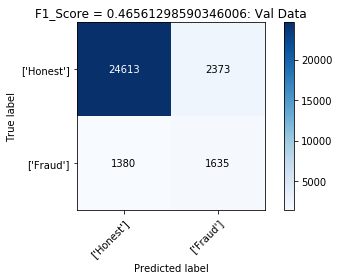

Confusion matrix, without normalization
[[114905  11026]
 [ 19416  22788]]


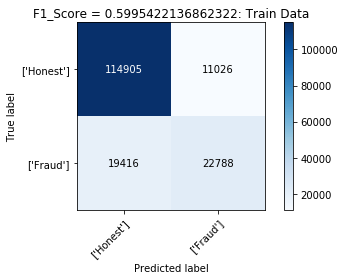

In [47]:
rna5.predict(x_data,y_data)